<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 102</h1>
<h1>All CoVID19 models are wrong, but some are useful</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [2]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [3]:
%watermark -n -v -m -g -iv

json      2.0.9
watermark 2.0.2
numpy     1.18.1
networkx  2.4
scipy     1.4.1
pandas    1.0.1
autopep8  1.5
Sat Apr 25 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 98d2c80f38539bac4ac81fc25a8c3e44ef9c20b4


Load default figure style and extract the color cycle for ease of reference

In [4]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## SIR Model

Our first step is to reimplement the SIR model from the previous post

In [5]:
beta = 0.2
mu = 0.1

SIR = EpiModel()
SIR.add_interaction('S', 'I', 'I', beta)
SIR.add_spontaneous('I', 'R', mu)

We can easily make sure that it looks correct

In [6]:
print(SIR)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.200000
I -> R 0.100000



And we integrate it using our standard parameter values

In [7]:
N = 100000
I0 = 10

SIR.integrate(365, S=N-I0, I=I0, R=0)

And a quick visualization

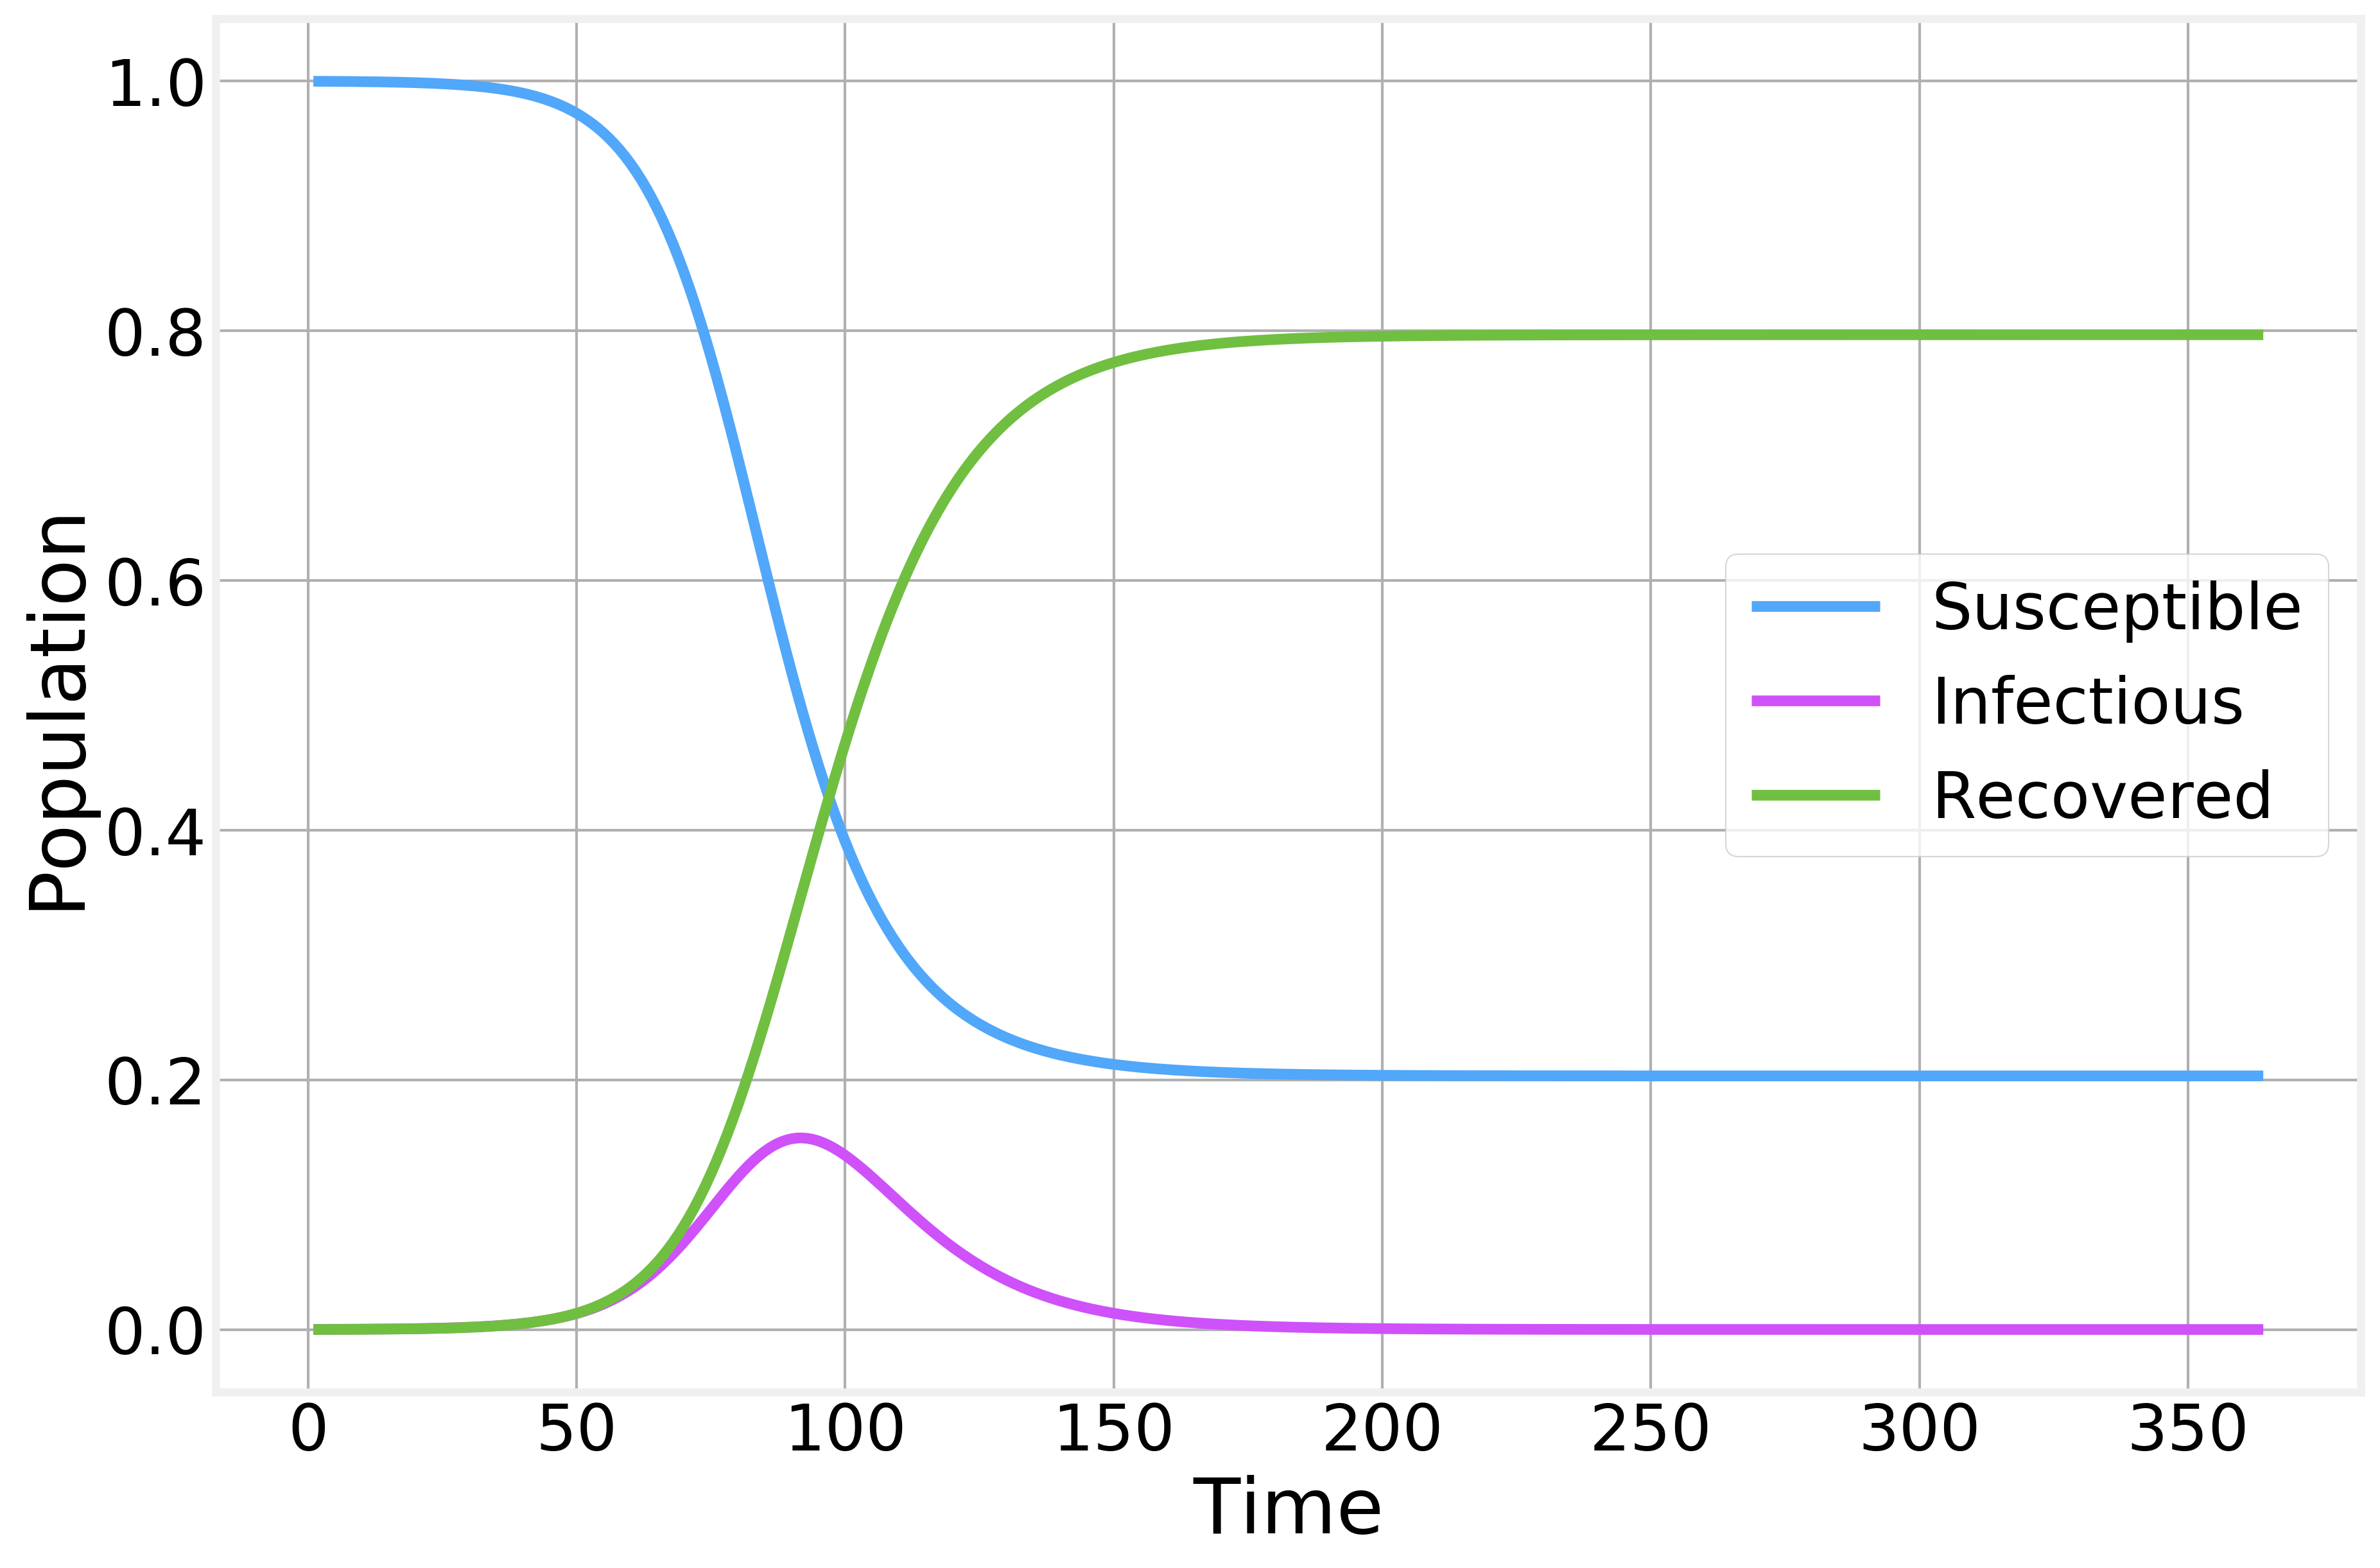

In [8]:
ax = SIR.plot(normed=True)
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

This will be the basis that we will build up on.

## Incubation Period - SEIR Model

One of the main factors that is missing from the simple SIR model, is that a Latent or incubation period. We can add this feature to our model by creating a new compartment E(xposed) that is Infected, but not yet infectious. The parameter $\epsilon$ determines the rate at which individuals develop the ability to infect others

In [10]:
epsilon = 0.4

SEIR = EpiModel()
SEIR.add_interaction('S', 'E', 'I', beta)
SEIR.add_spontaneous('E', 'I', epsilon)
SEIR.add_spontaneous('I', 'R', mu)

Now we have a third transition

In [11]:
print(SEIR)

Epidemic Model with 4 compartments and 3 transitions:

S + I = E 0.200000
E -> I 0.400000
I -> R 0.100000



Which has a direct impact on the time line of the system

In [12]:
SEIR.integrate(365, S=N-I0, E=0, I=I0, R=0)

The value of $R_0$ remains the same, but the epidemic takes place over a longer timeframe

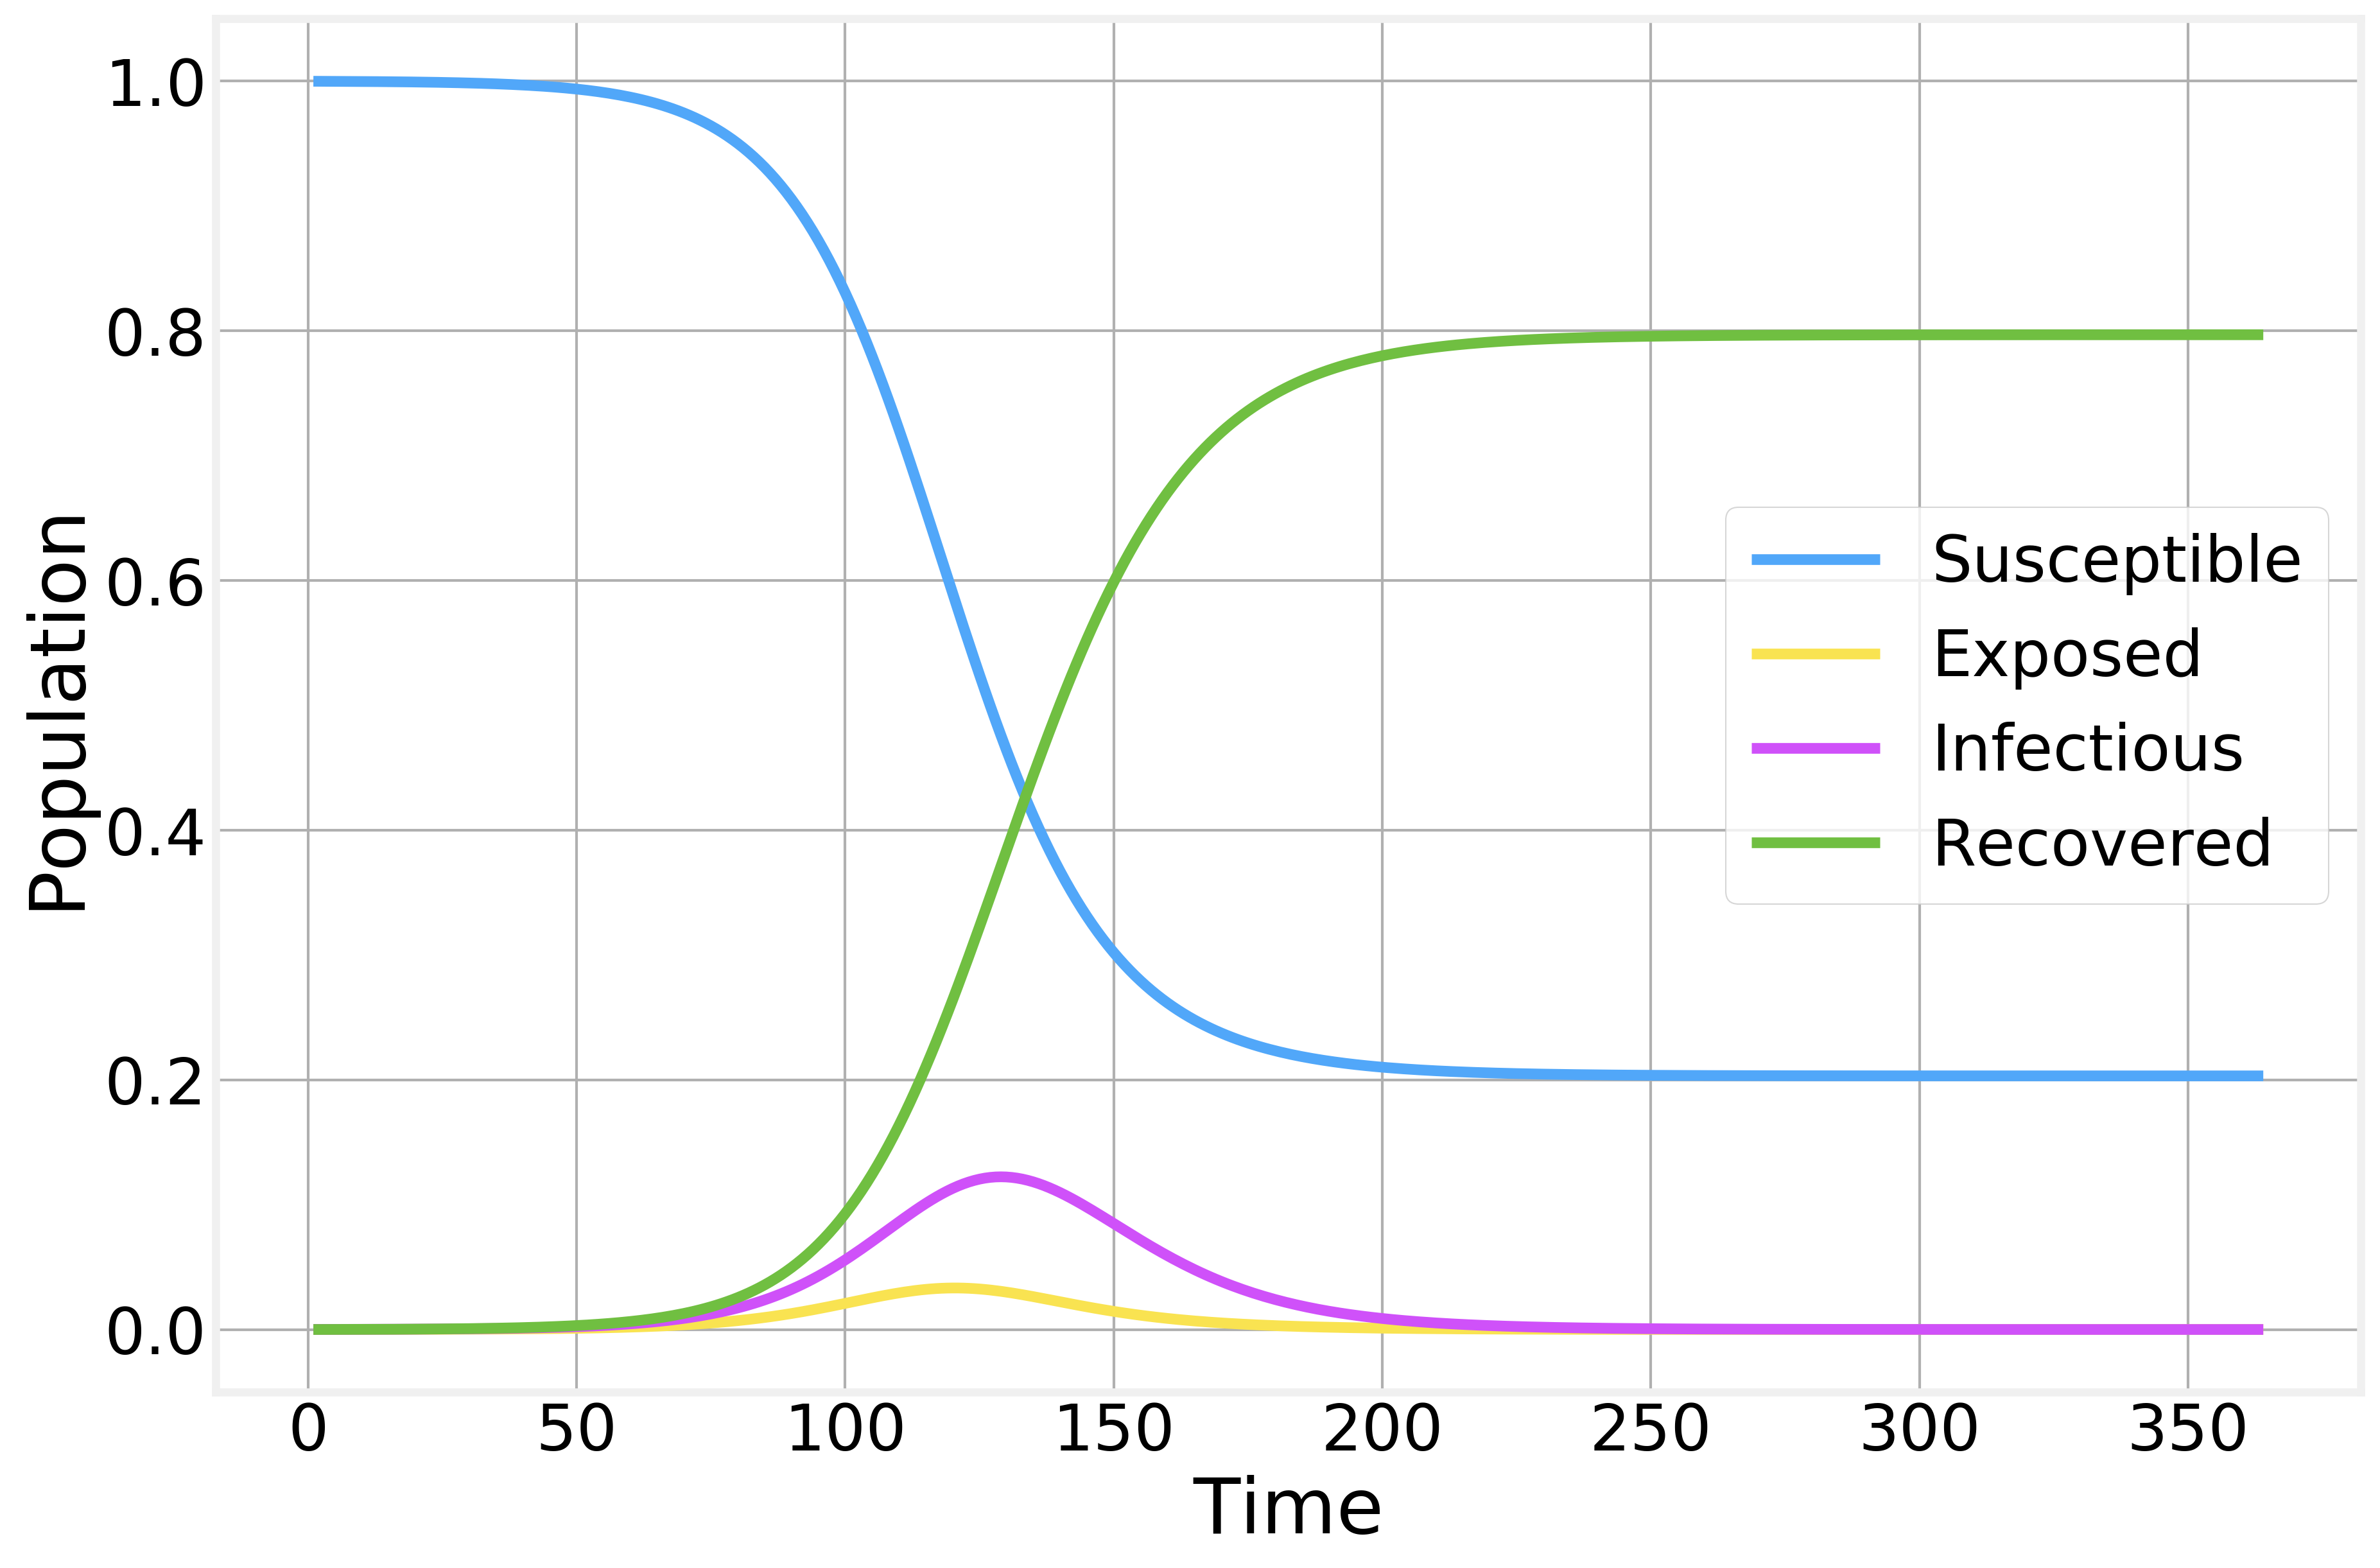

In [13]:
ax = SEIR.plot(normed=True, color=[colors[0], colors[4], colors[1], colors[2]])
ax.legend(['Susceptible', 'Exposed', 'Infectious', 'Recovered'])

We can easily illustrate this by simply plotting the infected compartments of the SIR and SEIR models, side by side.

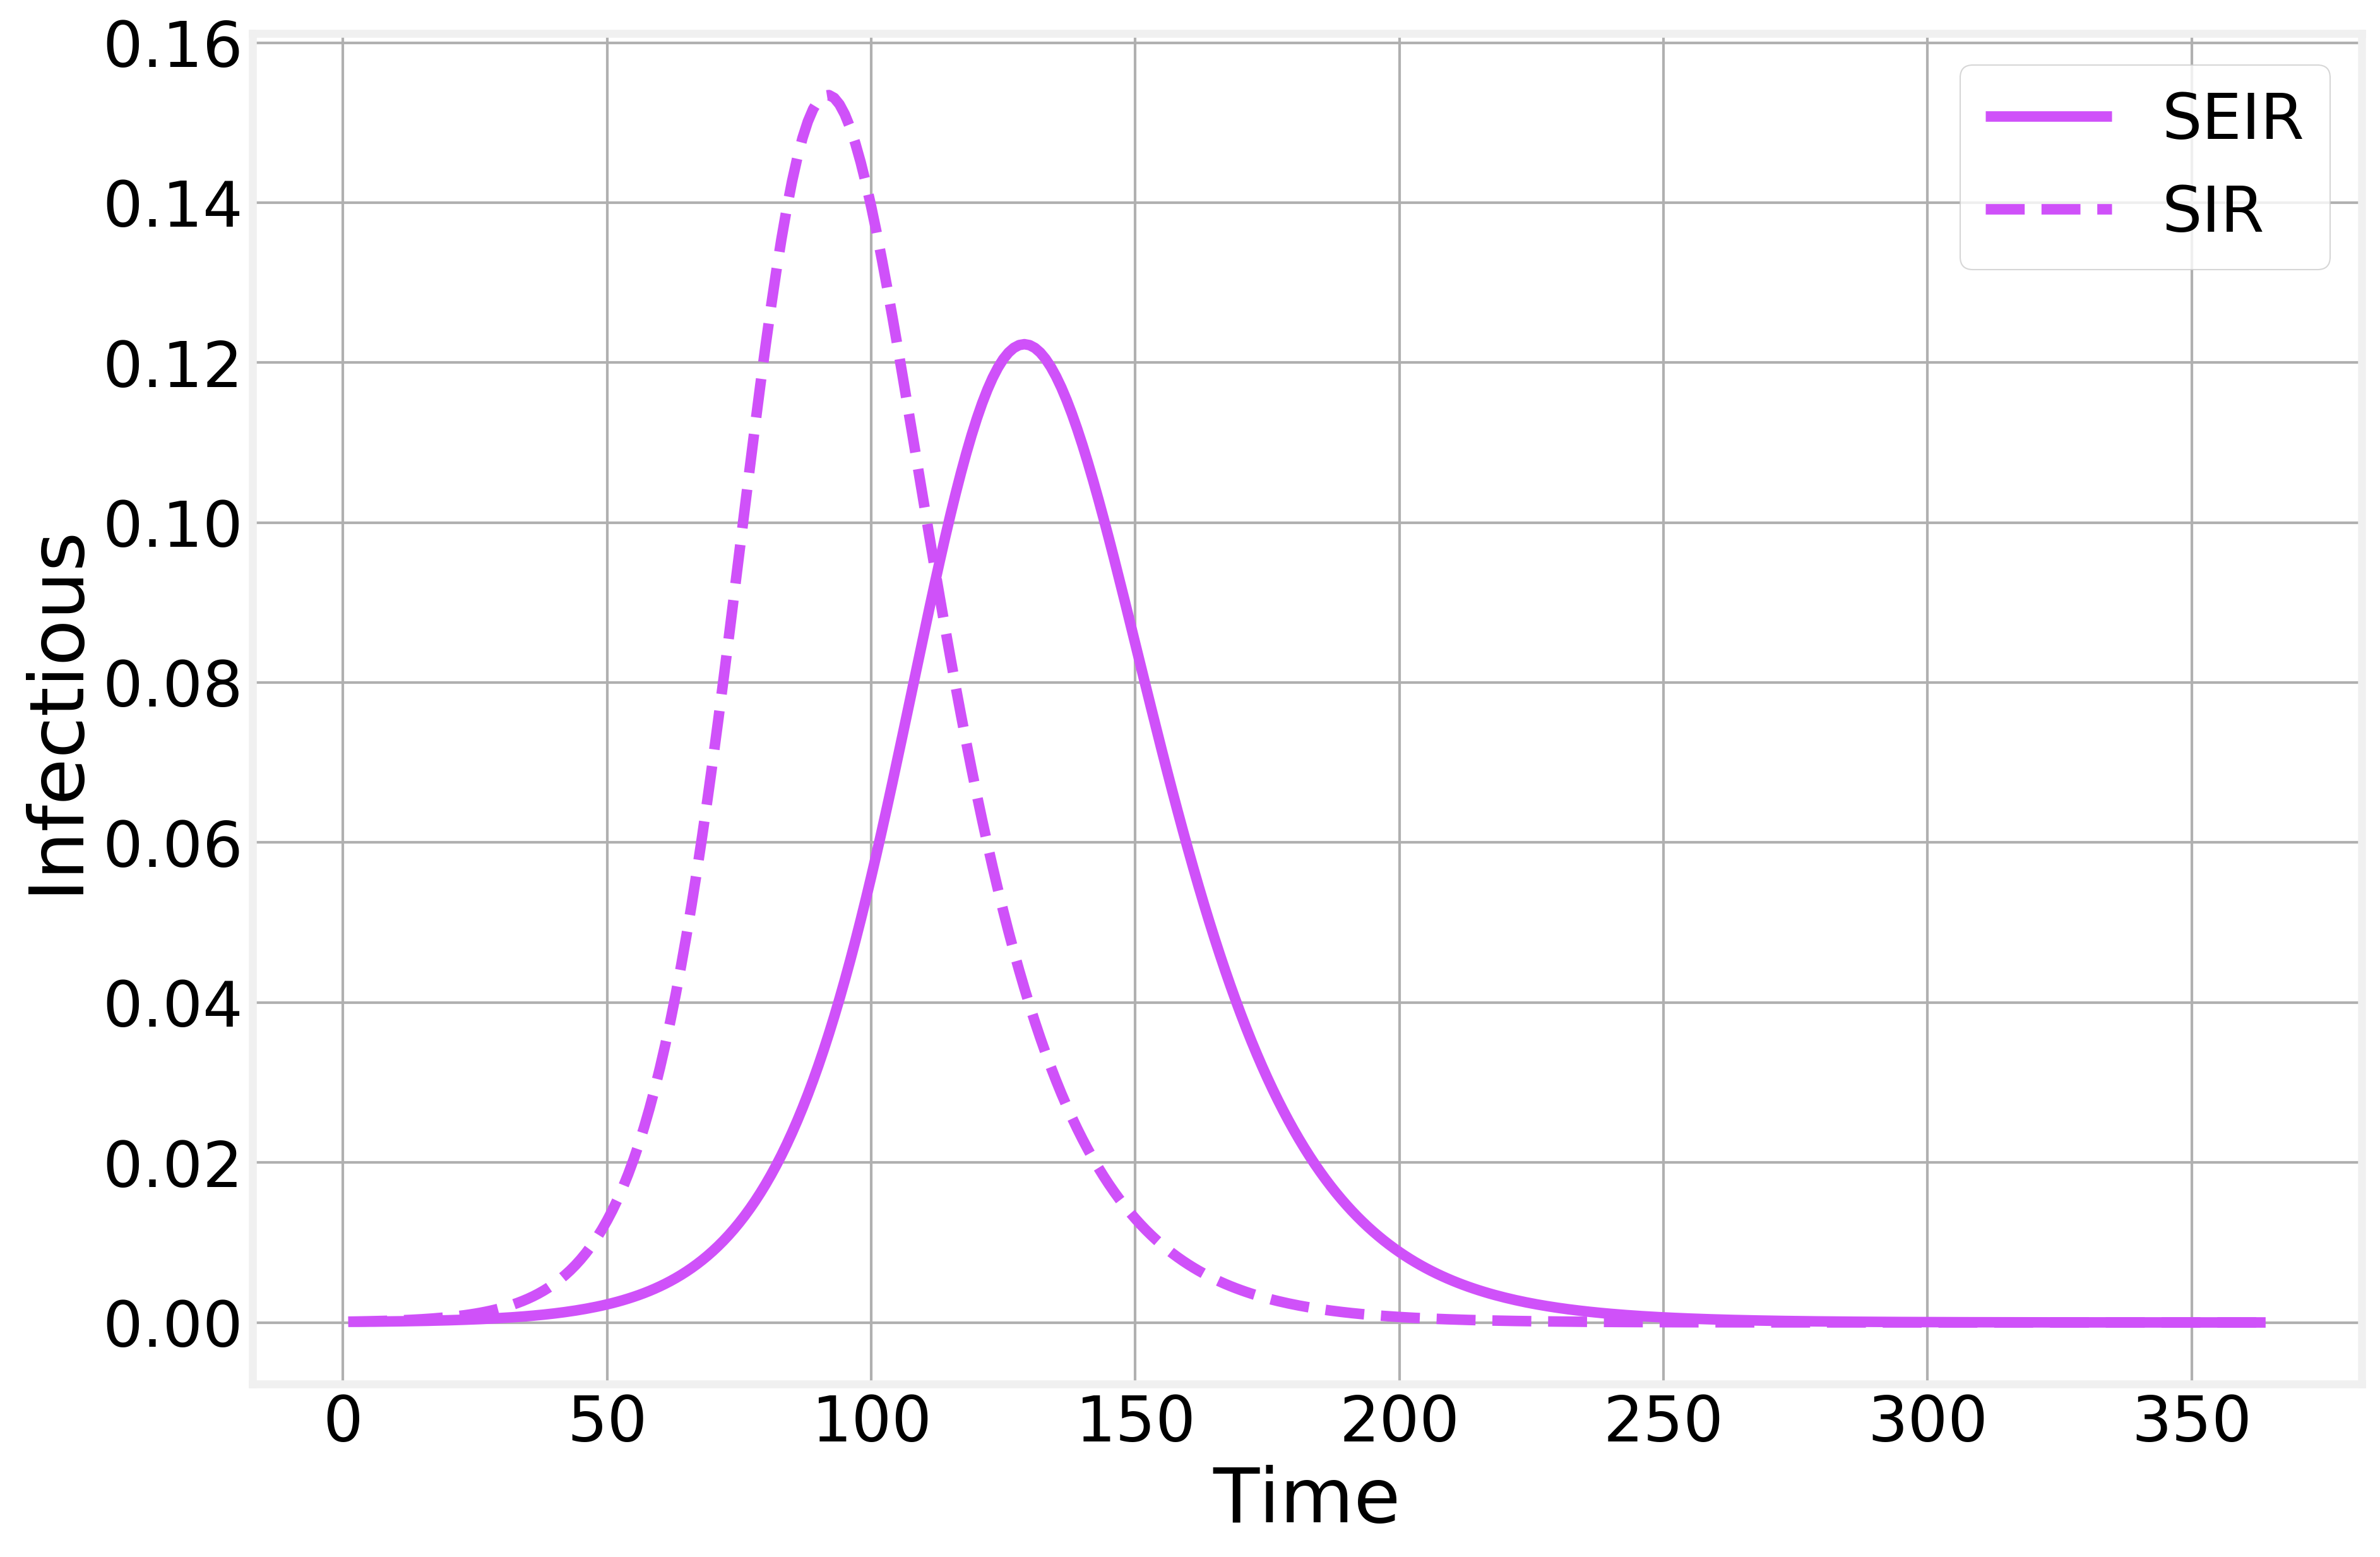

In [15]:
ax = (SEIR.I/N).plot(color=colors[1], linestyle='-', label='SEIR')
(SIR.I/N).plot(color=colors[1], linestyle='--', label='SIR', ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Infectious')
ax.legend()

We clearly see that the presence of an Esposed compartment causes a delay in the number of infectious individuals as well as a flattening of the curve

## Temporary Immunity

There have been recent reports that immunity might not be permanent for those who recover from the infection. We can easily add this feature to our model by including an extra transition from the *Recovered* compartment back to *Susceptible*

In [17]:
rho = 0.3

SEIRS = EpiModel()
SEIRS.add_interaction('S', 'E', 'I', beta)
SEIRS.add_spontaneous('E', 'I', epsilon)
SEIRS.add_spontaneous('I', 'R', mu)
SEIRS.add_spontaneous('R', 'S', rho)

Naturally, the time scale of the system depend on the exact value of $\rho$ chosen, but the main features will remain the same. Our model is now:

In [18]:
print(SEIRS)

Epidemic Model with 4 compartments and 4 transitions:

S + I = E 0.200000
E -> I 0.400000
I -> R 0.100000
R -> S 0.300000



Let's integrate the equations of the model and examine the result

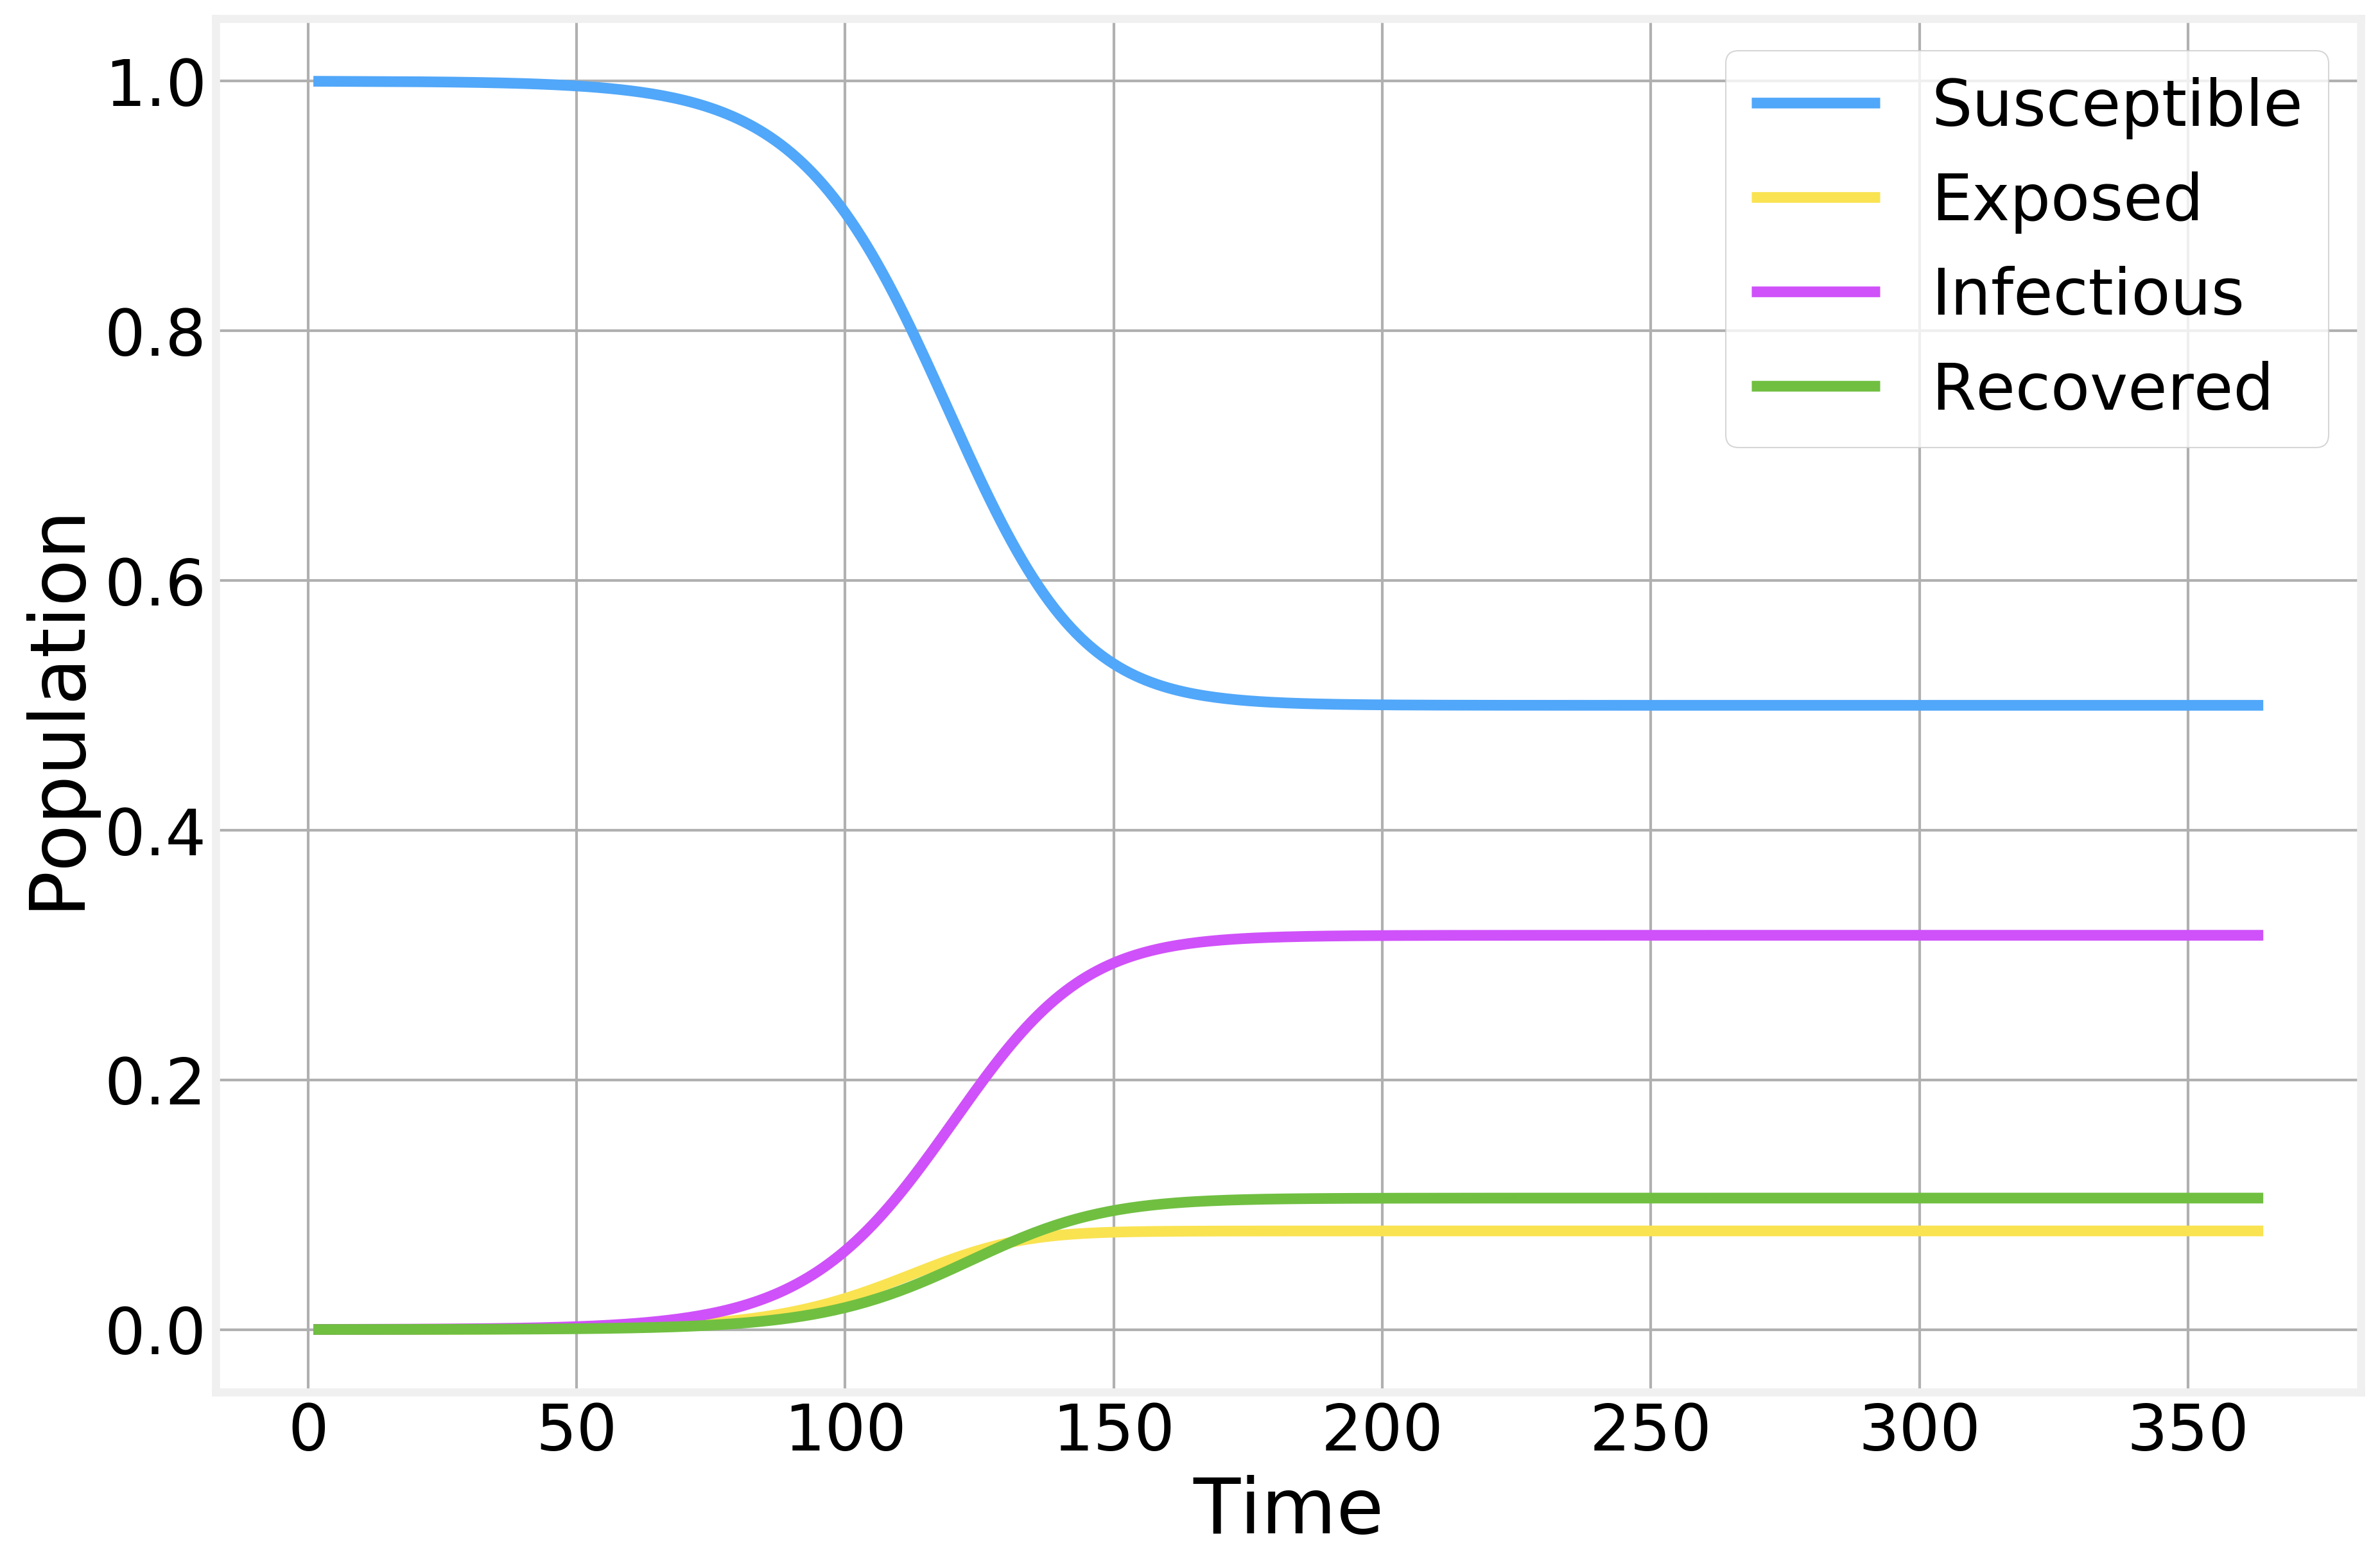

In [19]:
SEIRS.integrate(365, S=N-I0, E=0, I=I0, R=0)

ax = SEIRS.plot(normed=True, color=[colors[0], colors[4], colors[1], colors[2]])
ax.legend(['Susceptible', 'Exposed', 'Infectious', 'Recovered'])

In [17]:
rho = 0.03

SEIRS2 = EpiModel()
SEIRS2.add_interaction('S', 'E', 'I', beta)
SEIRS2.add_spontaneous('E', 'I', epsilon)
SEIRS2.add_spontaneous('I', 'R', mu)
SEIRS2.add_spontaneous('R', 'S', rho)

In [18]:
SEIRS2.integrate(365, S=N-I0, E=0, I=I0, R=0)

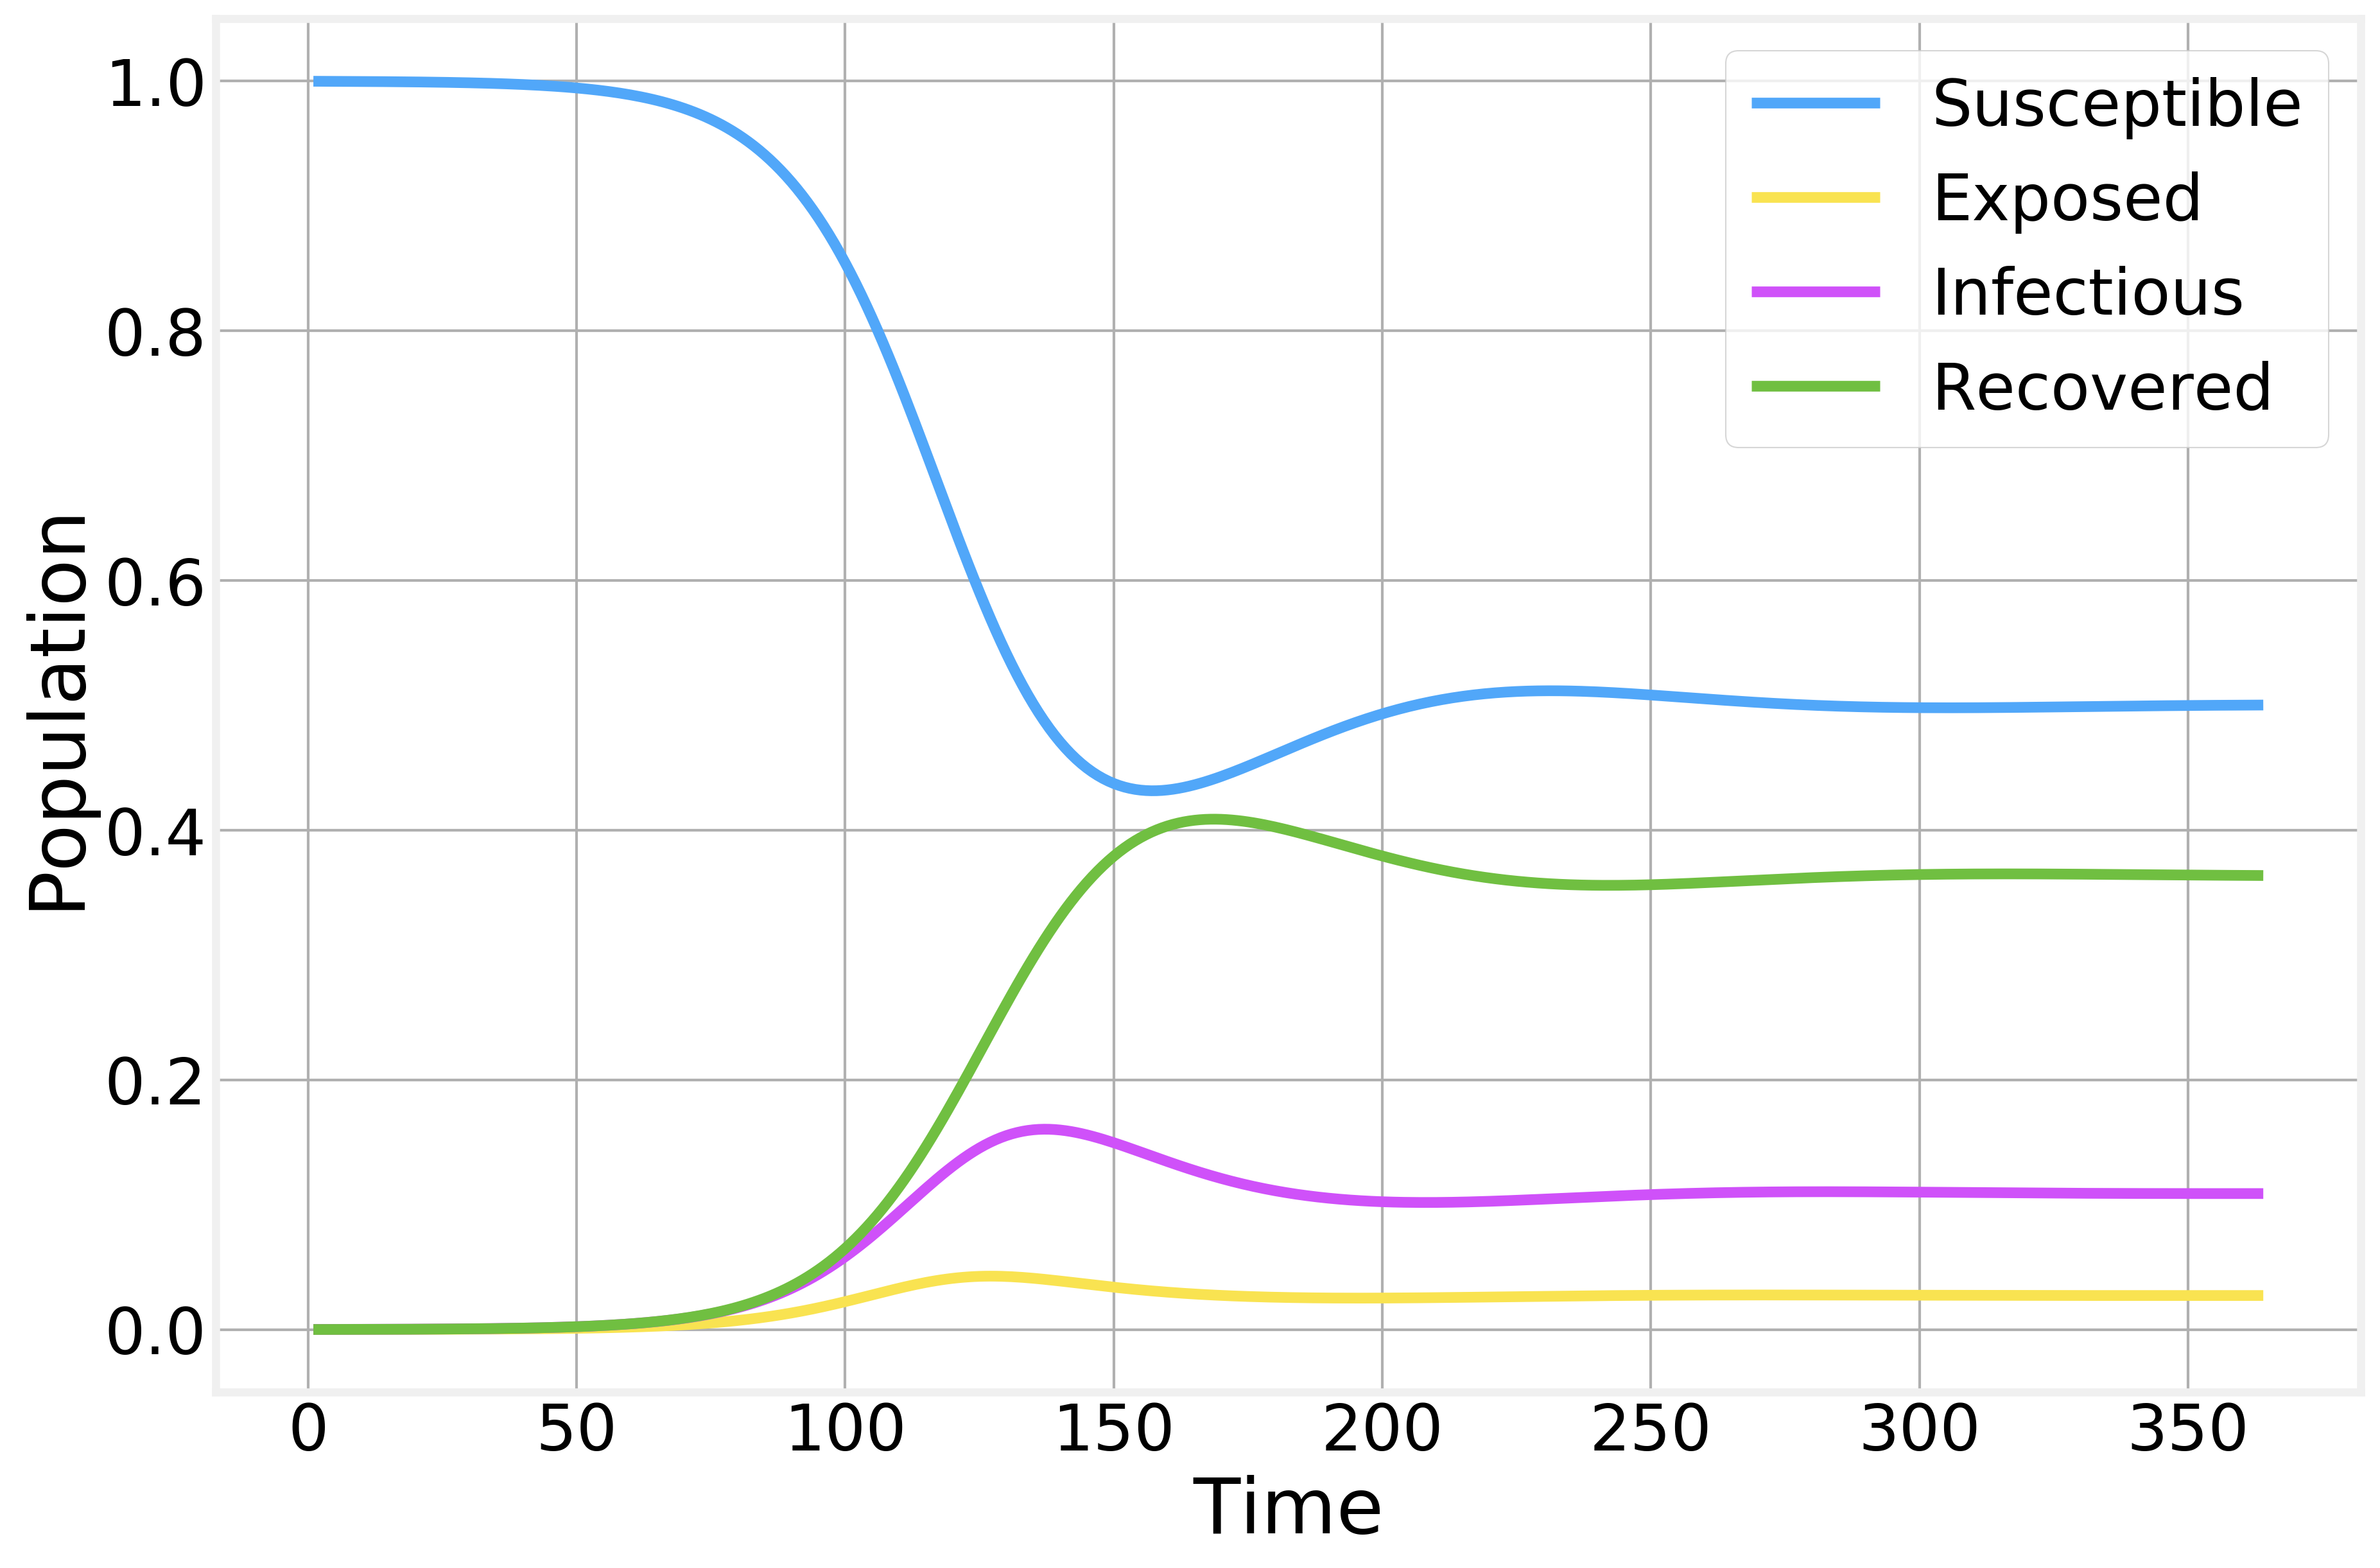

In [19]:
ax = SEIRS2.plot(normed=True, color=[colors[0], colors[4], colors[1], colors[2]])
ax.legend(['Susceptible', 'Exposed', 'Infectious', 'Recovered'])

Text(0, 0.5, 'Population')

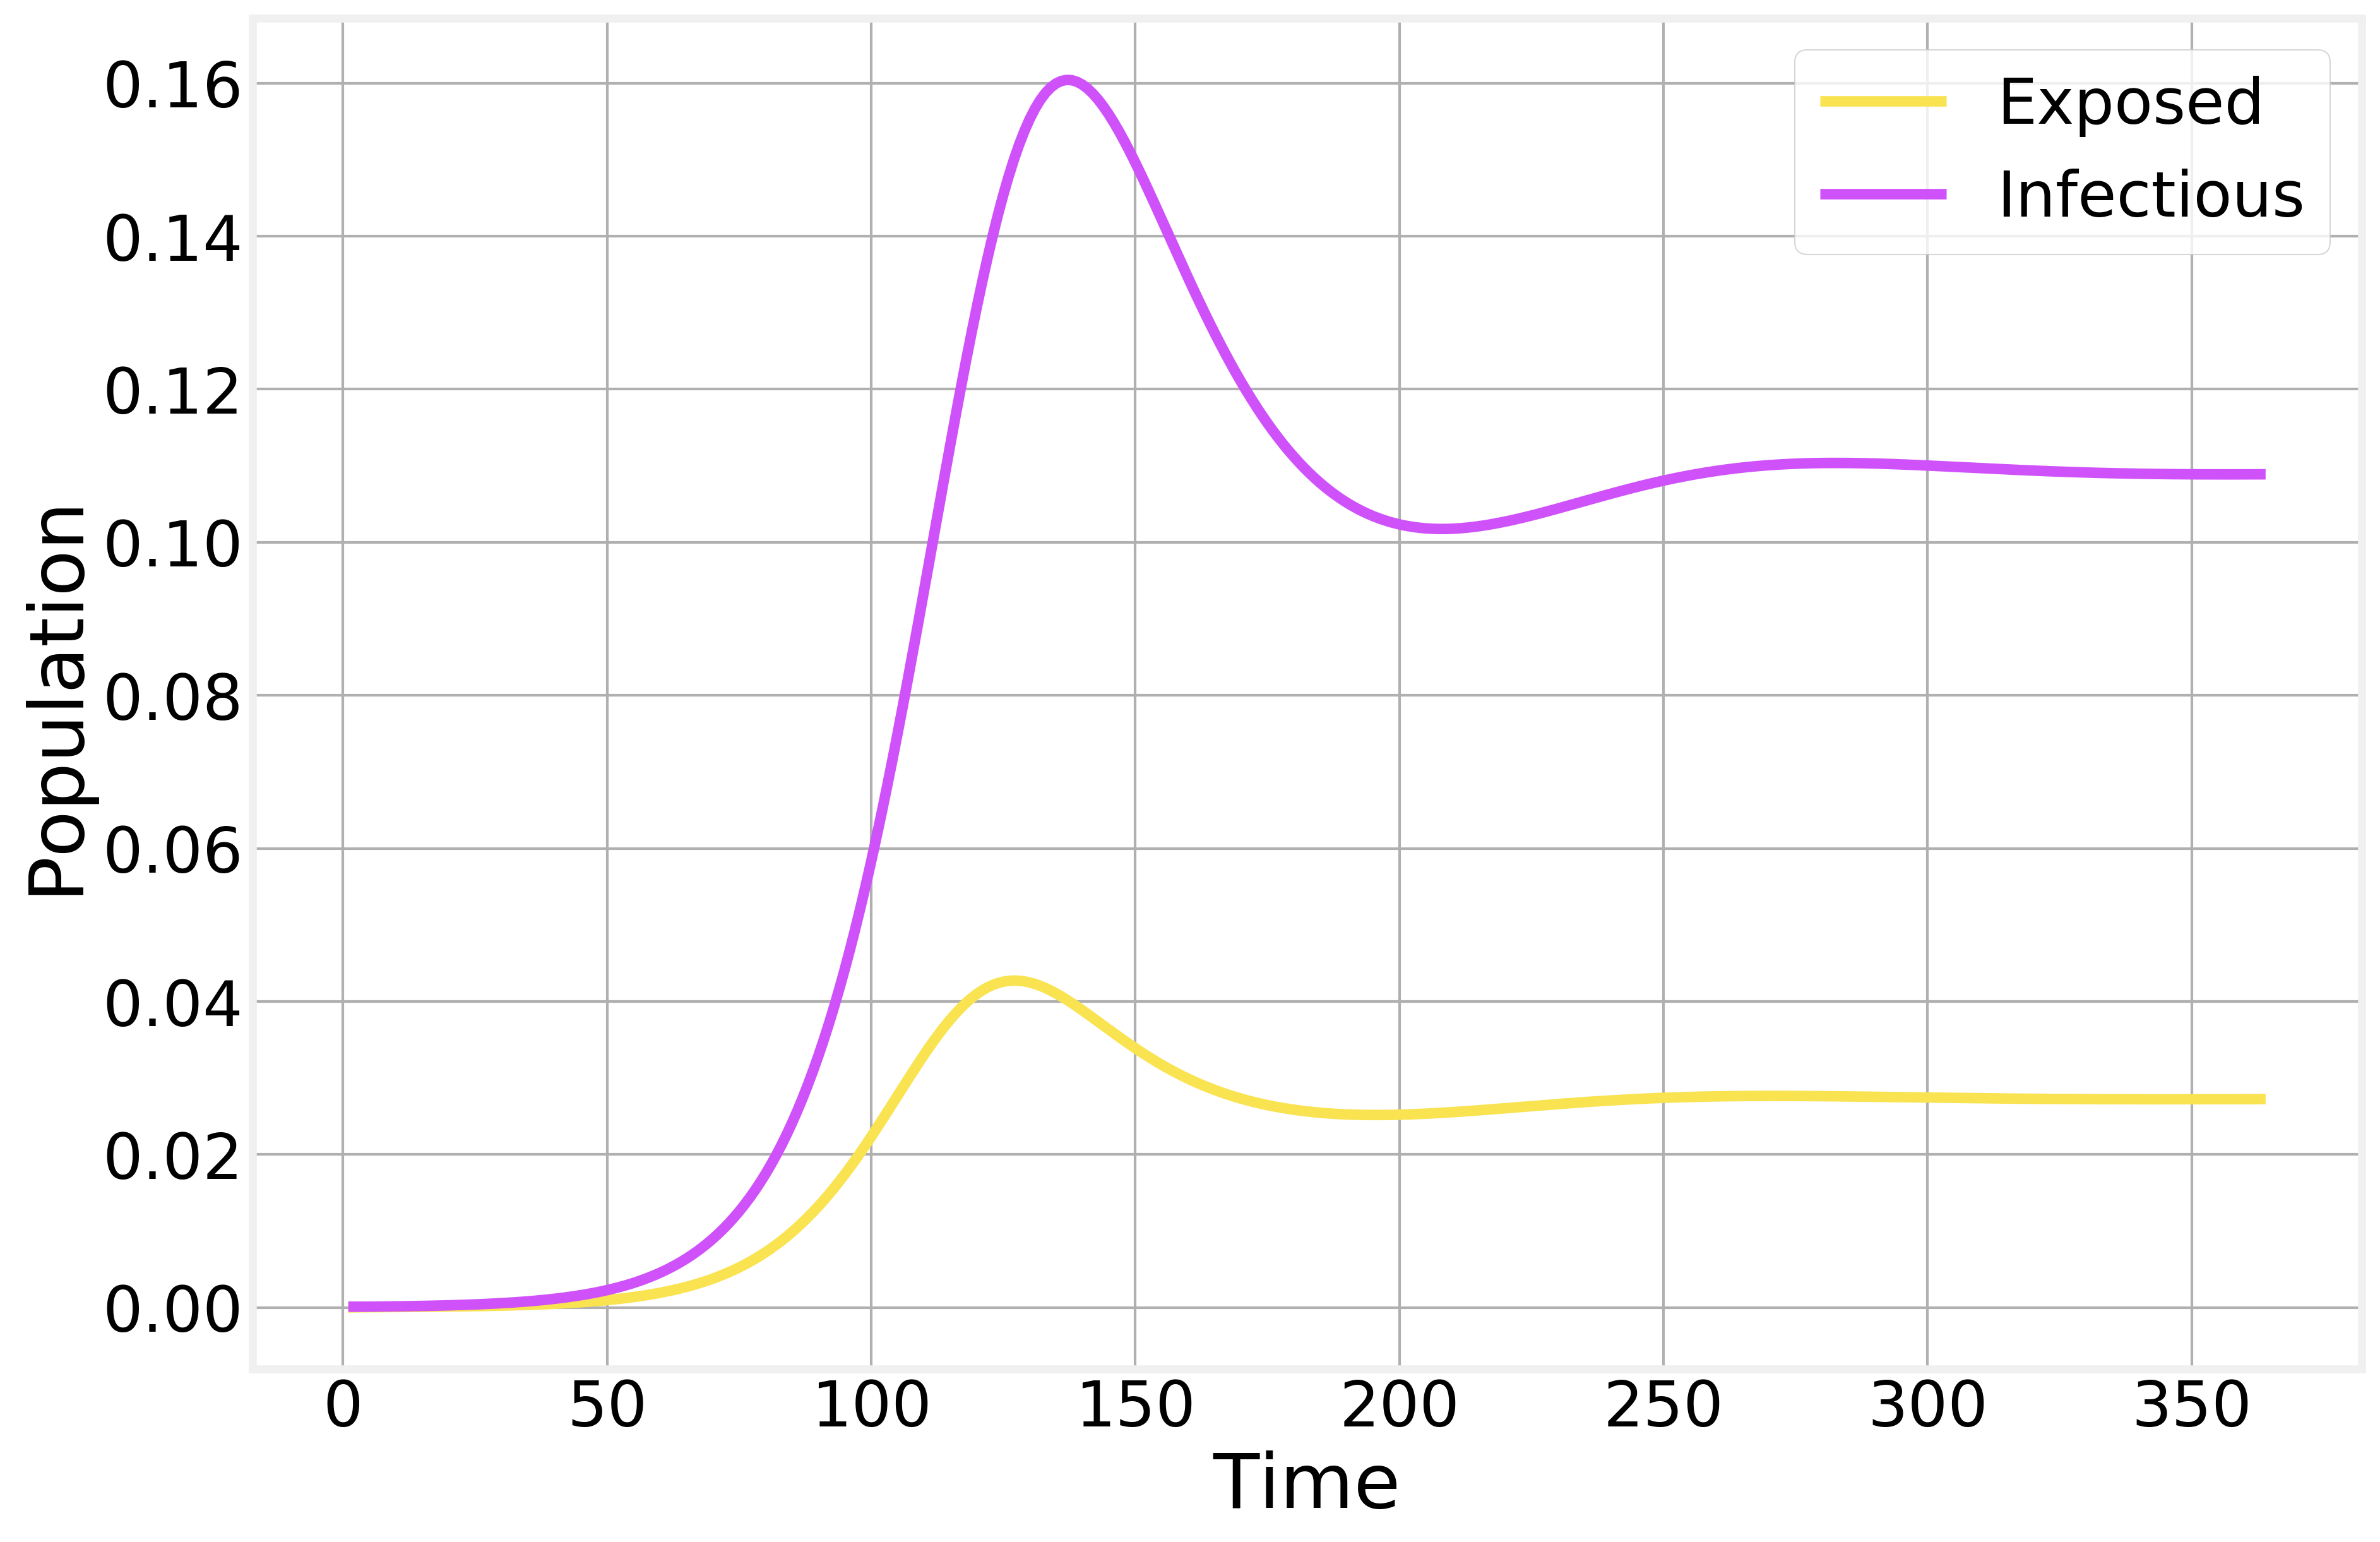

In [20]:
ax = (SEIRS2.E/N).plot(color=colors[4])
(SEIRS2.I/N).plot(color=colors[1], ax=ax)
ax.legend(['Exposed', 'Infectious'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

## Asymptomatic cases

In [21]:
rbeta = 0.75
pa = 0.4
R0 = 2.0

beta = R0*mu/(pa*rbeta+(1-pa))

SEIIR = EpiModel()
SEIIR.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIR.add_interaction('S', 'E', 'Is', beta)
SEIIR.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIR.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIR.add_spontaneous('Ia', 'R', mu)
SEIIR.add_spontaneous('Is', 'R', mu)

In [22]:
print(SEIIR)

Epidemic Model with 5 compartments and 6 transitions:

S + Ia = E 0.166667
S + Is = E 0.222222
E -> Ia 0.160000
E -> Is 0.240000
Ia -> R 0.100000
Is -> R 0.100000



In [23]:
SEIIR.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0)

Text(0, 0.5, 'Population')

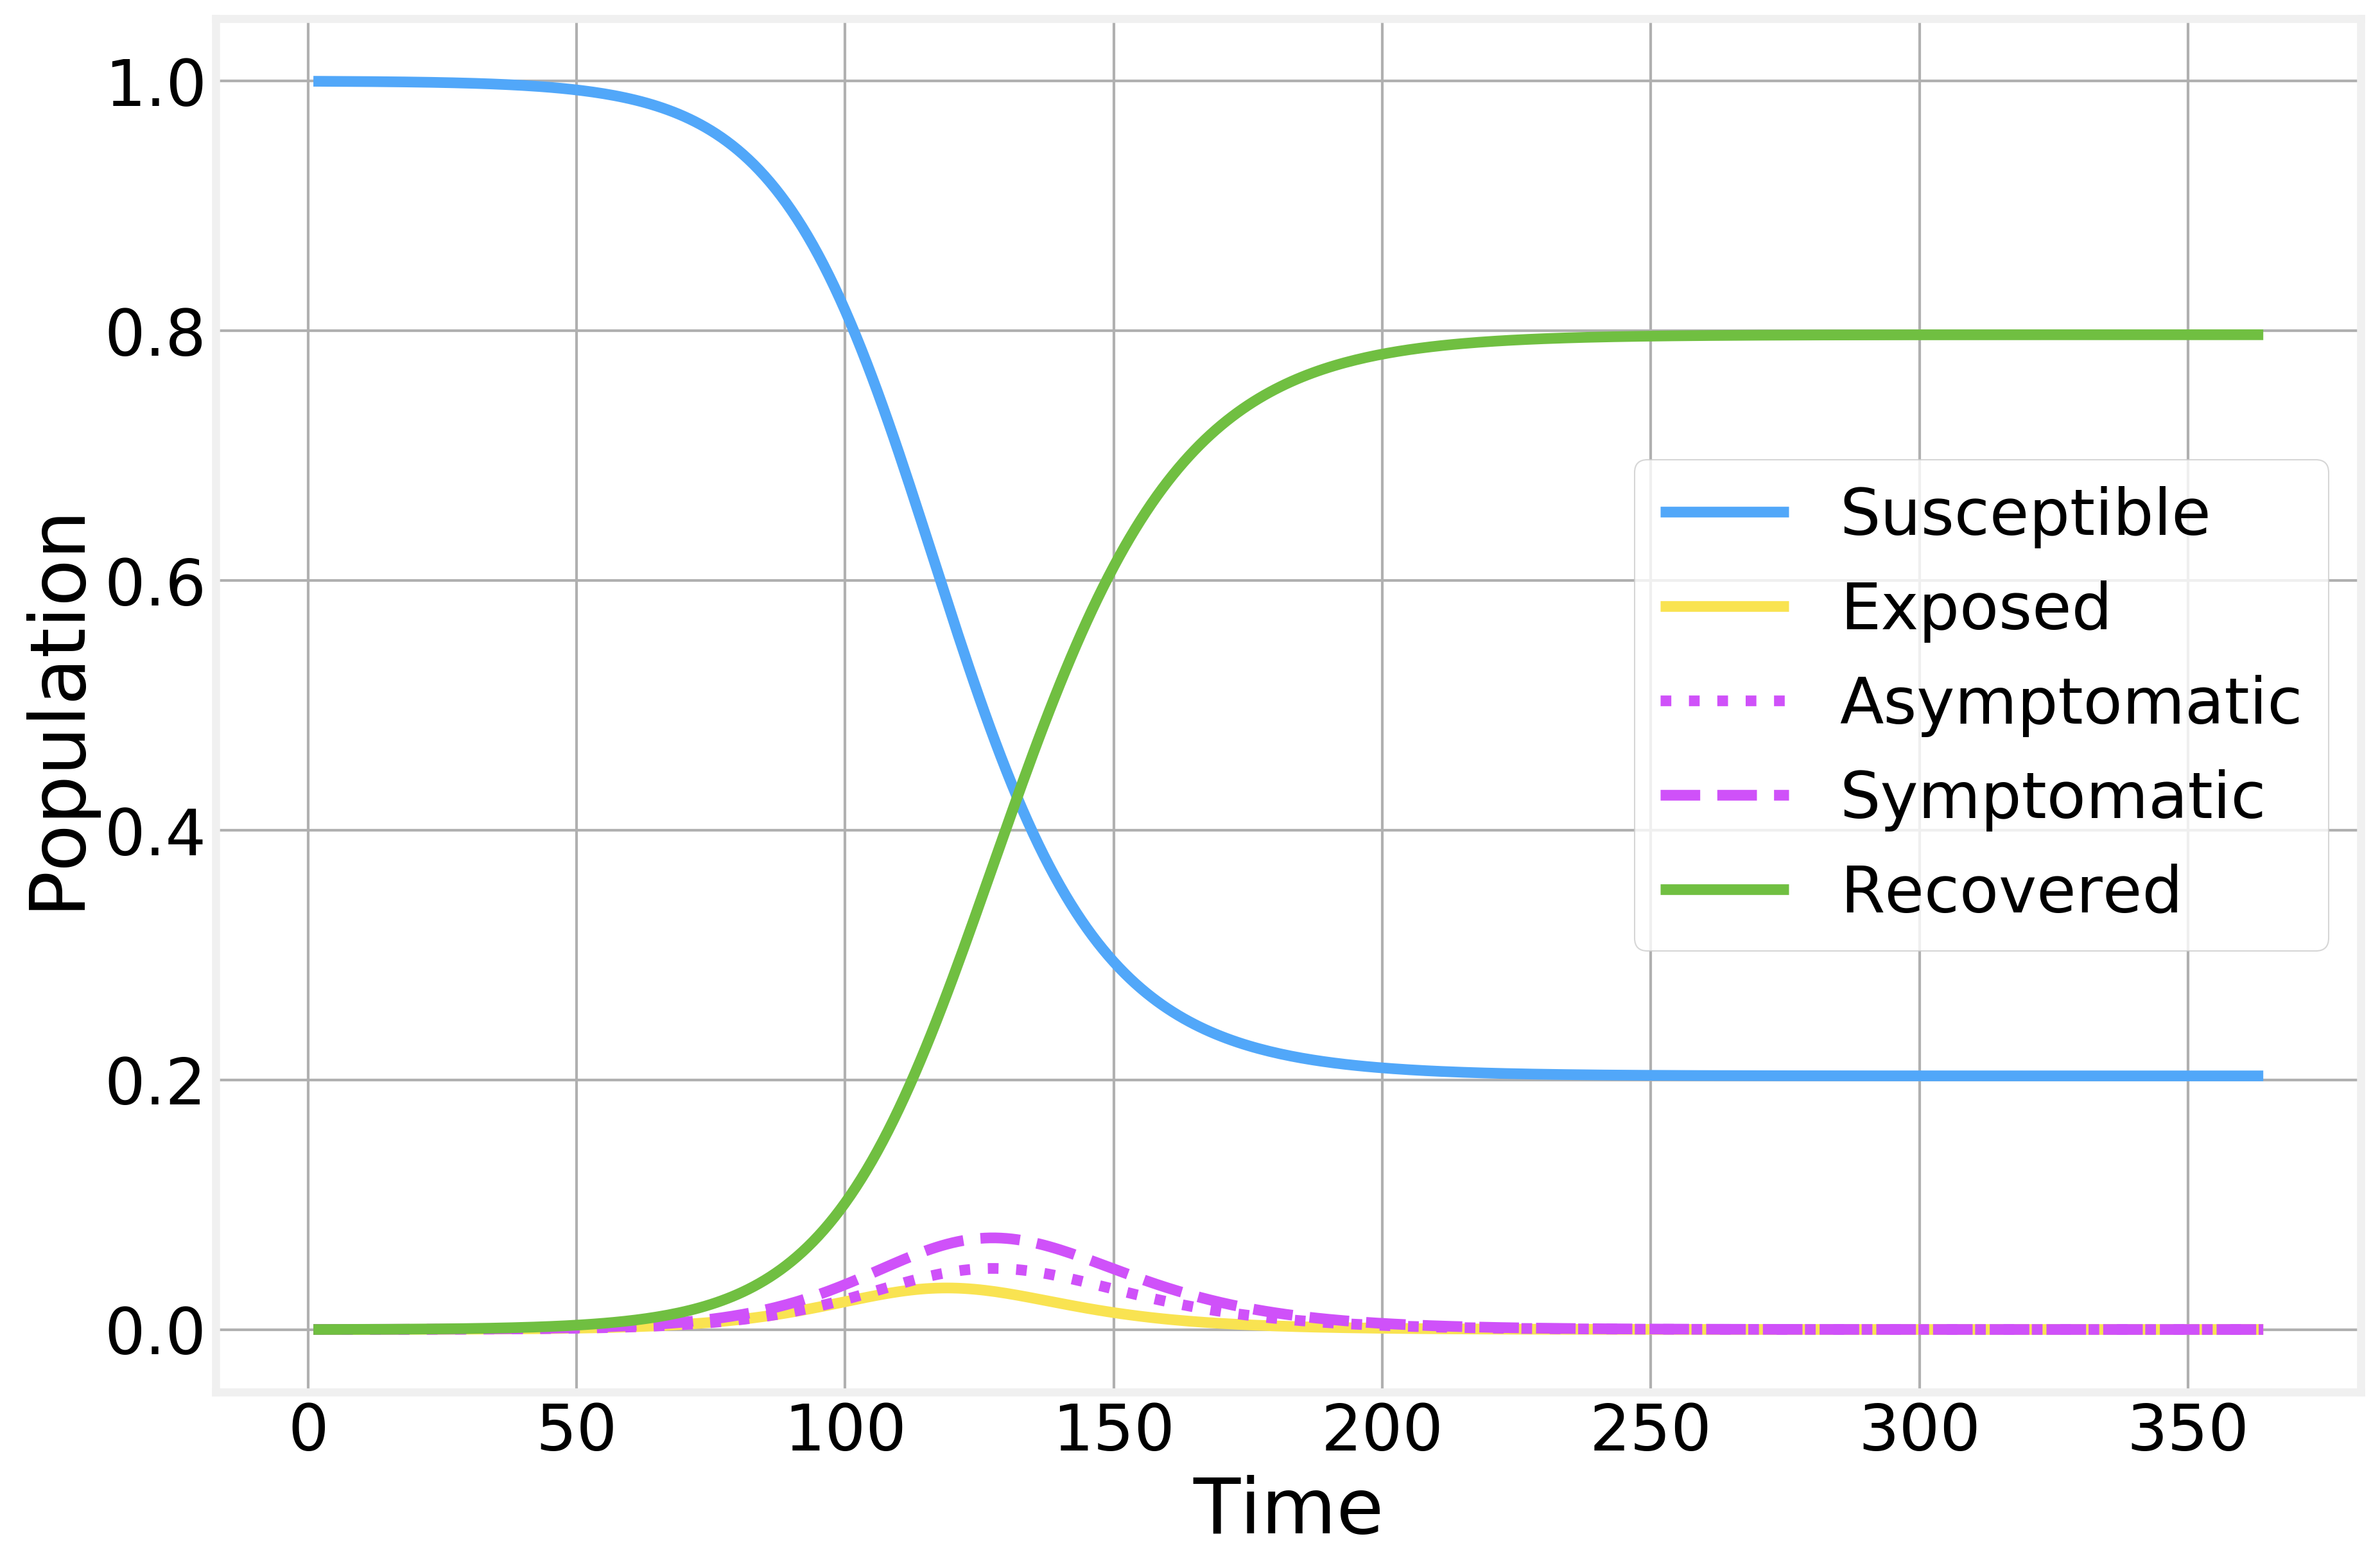

In [24]:
fig, ax = plt.subplots(1)
(SEIIR.S/N).plot(color=colors[0], linestyle='-', label='Susceptible', ax=ax)
(SEIIR.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(SEIIR.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(SEIIR.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)
(SEIIR.R/N).plot(color=colors[2], linestyle='-', label='Recovered', ax=ax)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

Text(0, 0.5, 'Population')

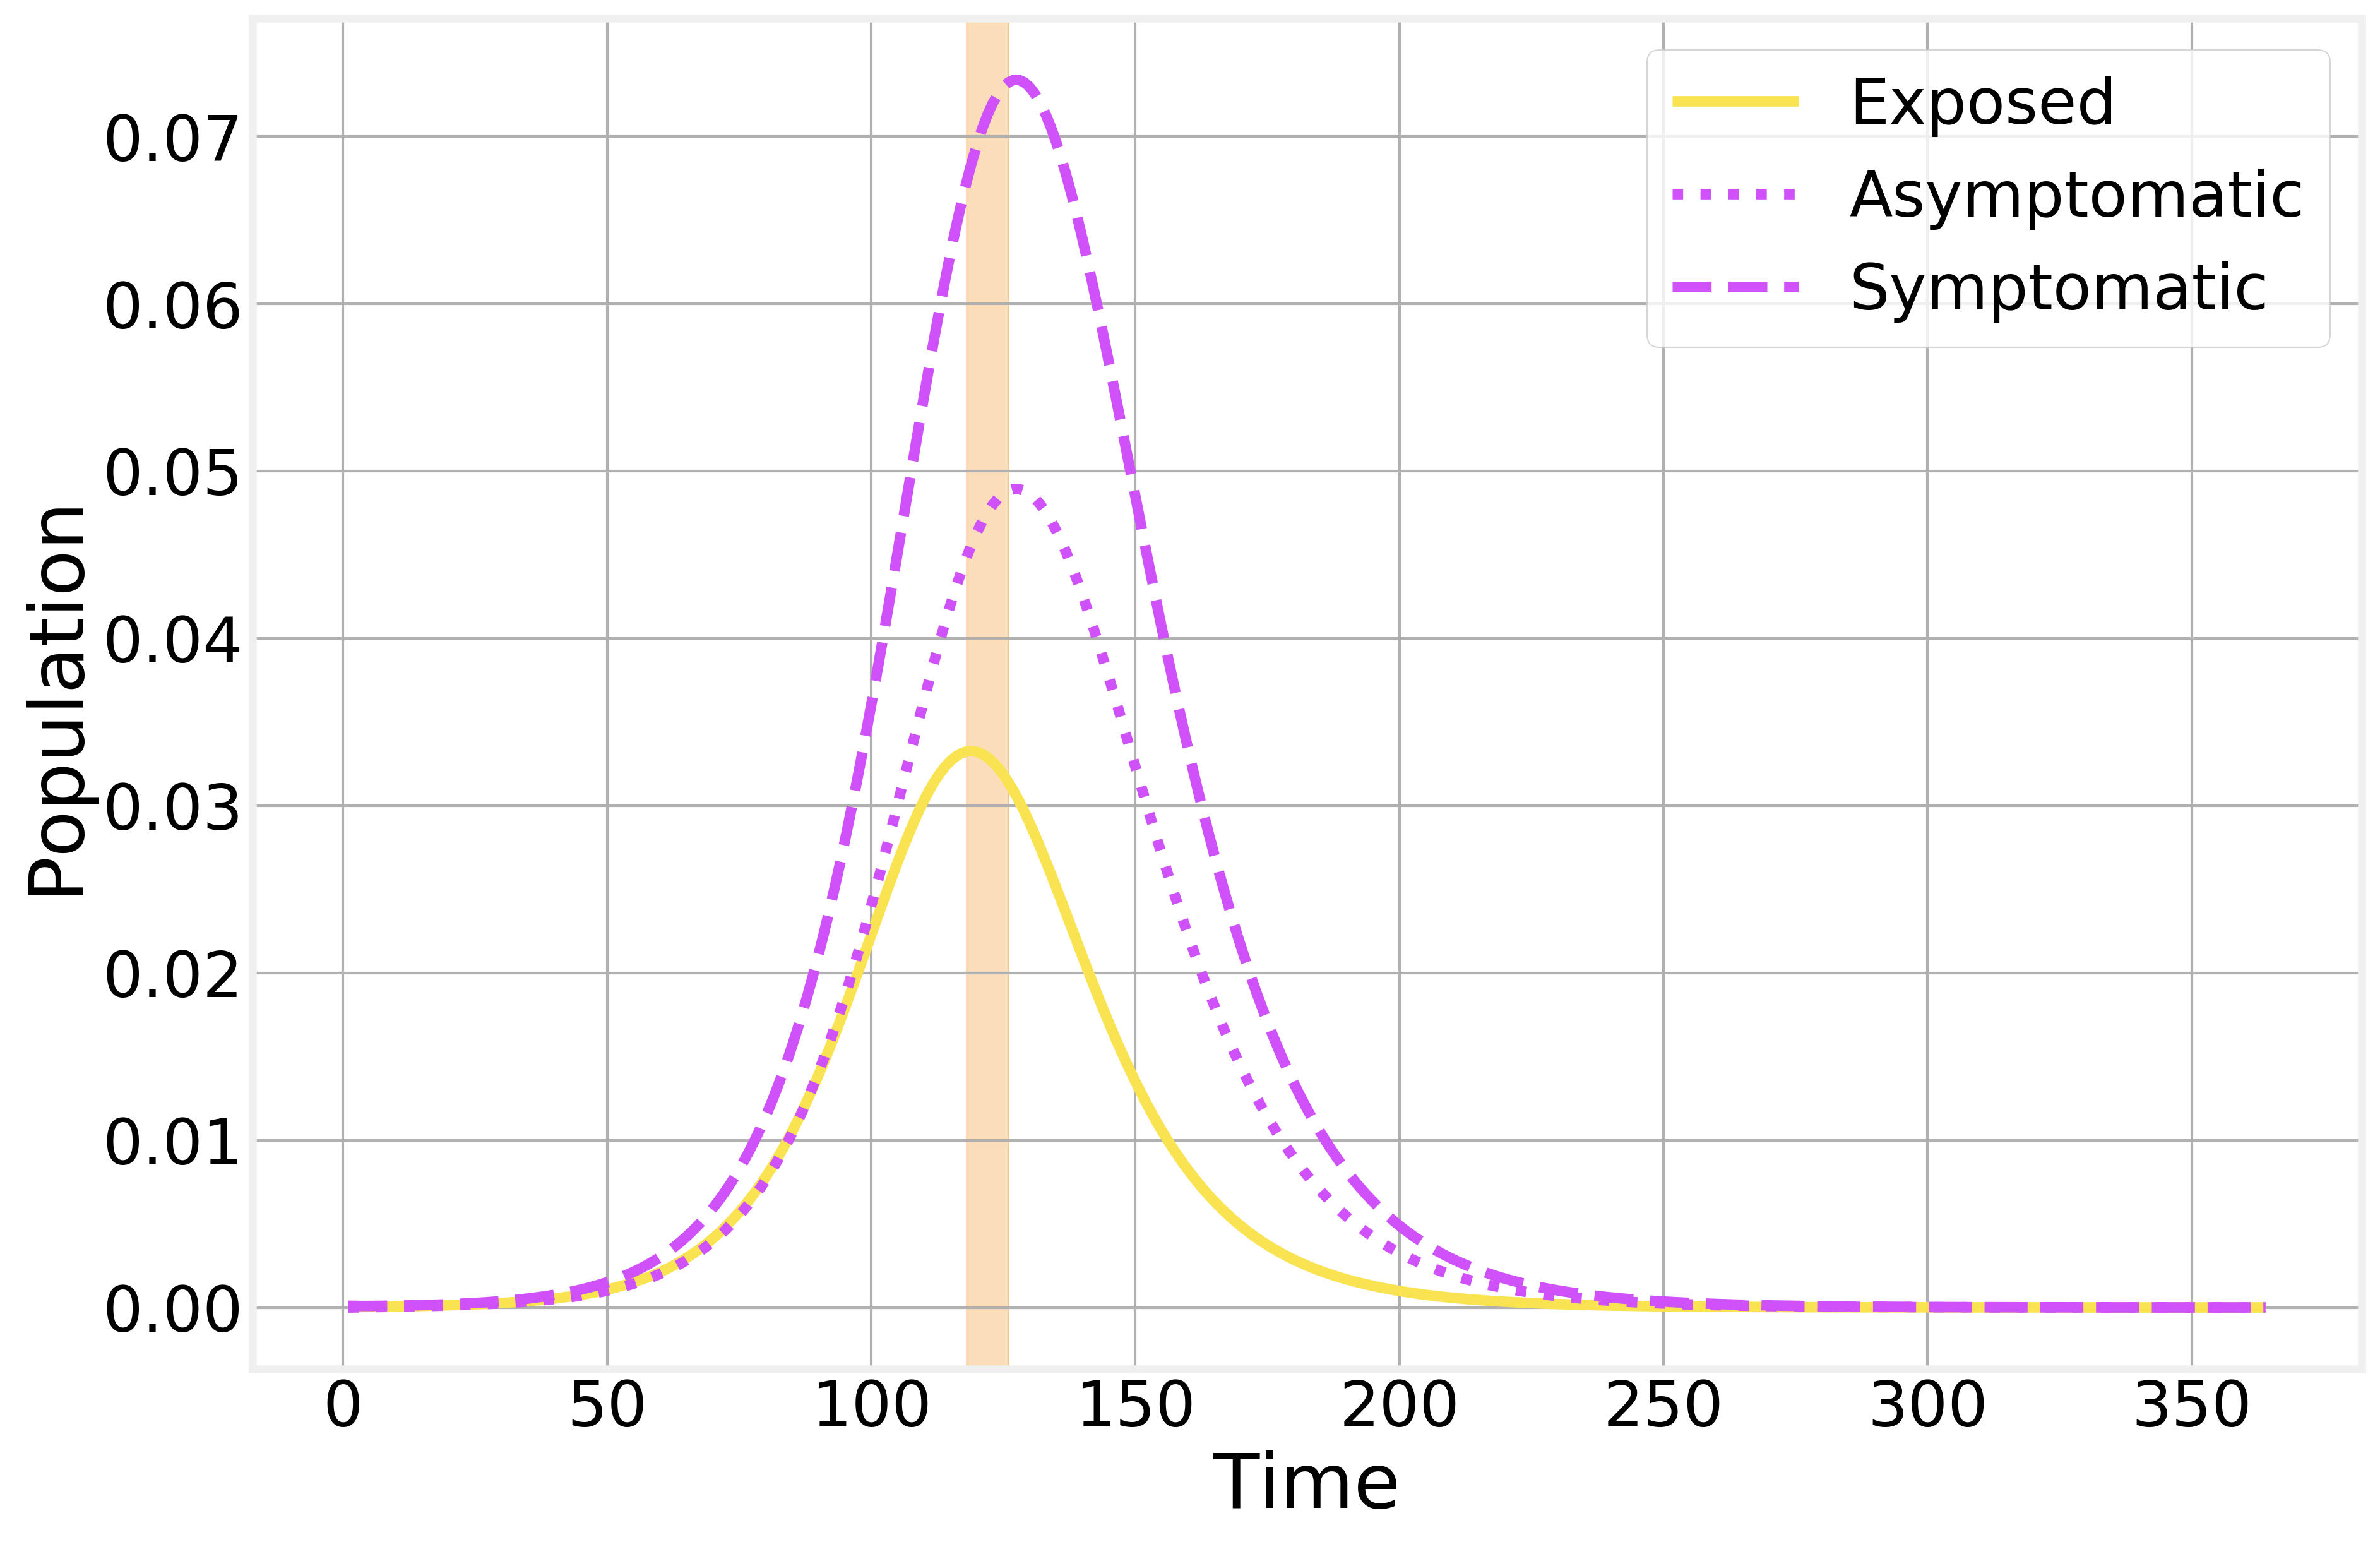

In [25]:
fig, ax = plt.subplots(1)
(SEIIR.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(SEIIR.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(SEIIR.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)

Emax = np.argmax(SEIIR.E)
Imax = np.argmax(SEIIR.Ia)

ax.axvspan(xmax=Imax, xmin=Emax, alpha=0.3, color=colors[3], zorder=-1)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

## Mortality

In [31]:
pd = 0.10

SEIIRD = EpiModel()
SEIIRD.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIRD.add_interaction('S', 'E', 'Is', beta)
SEIIRD.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIRD.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIRD.add_spontaneous('Ia', 'R', mu)
SEIIRD.add_spontaneous('Is', 'R', (1-pd)*mu)
SEIIRD.add_spontaneous('Is', 'D', pd*mu)

In [34]:
print(SEIIRD)

Epidemic Model with 6 compartments and 7 transitions:

S + Ia = E 0.166667
S + Is = E 0.222222
E -> Ia 0.160000
E -> Is 0.240000
Ia -> R 0.100000
Is -> R 0.090000
Is -> D 0.010000



In [35]:
SEIIRD.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)

Text(0, 0.5, 'Population')

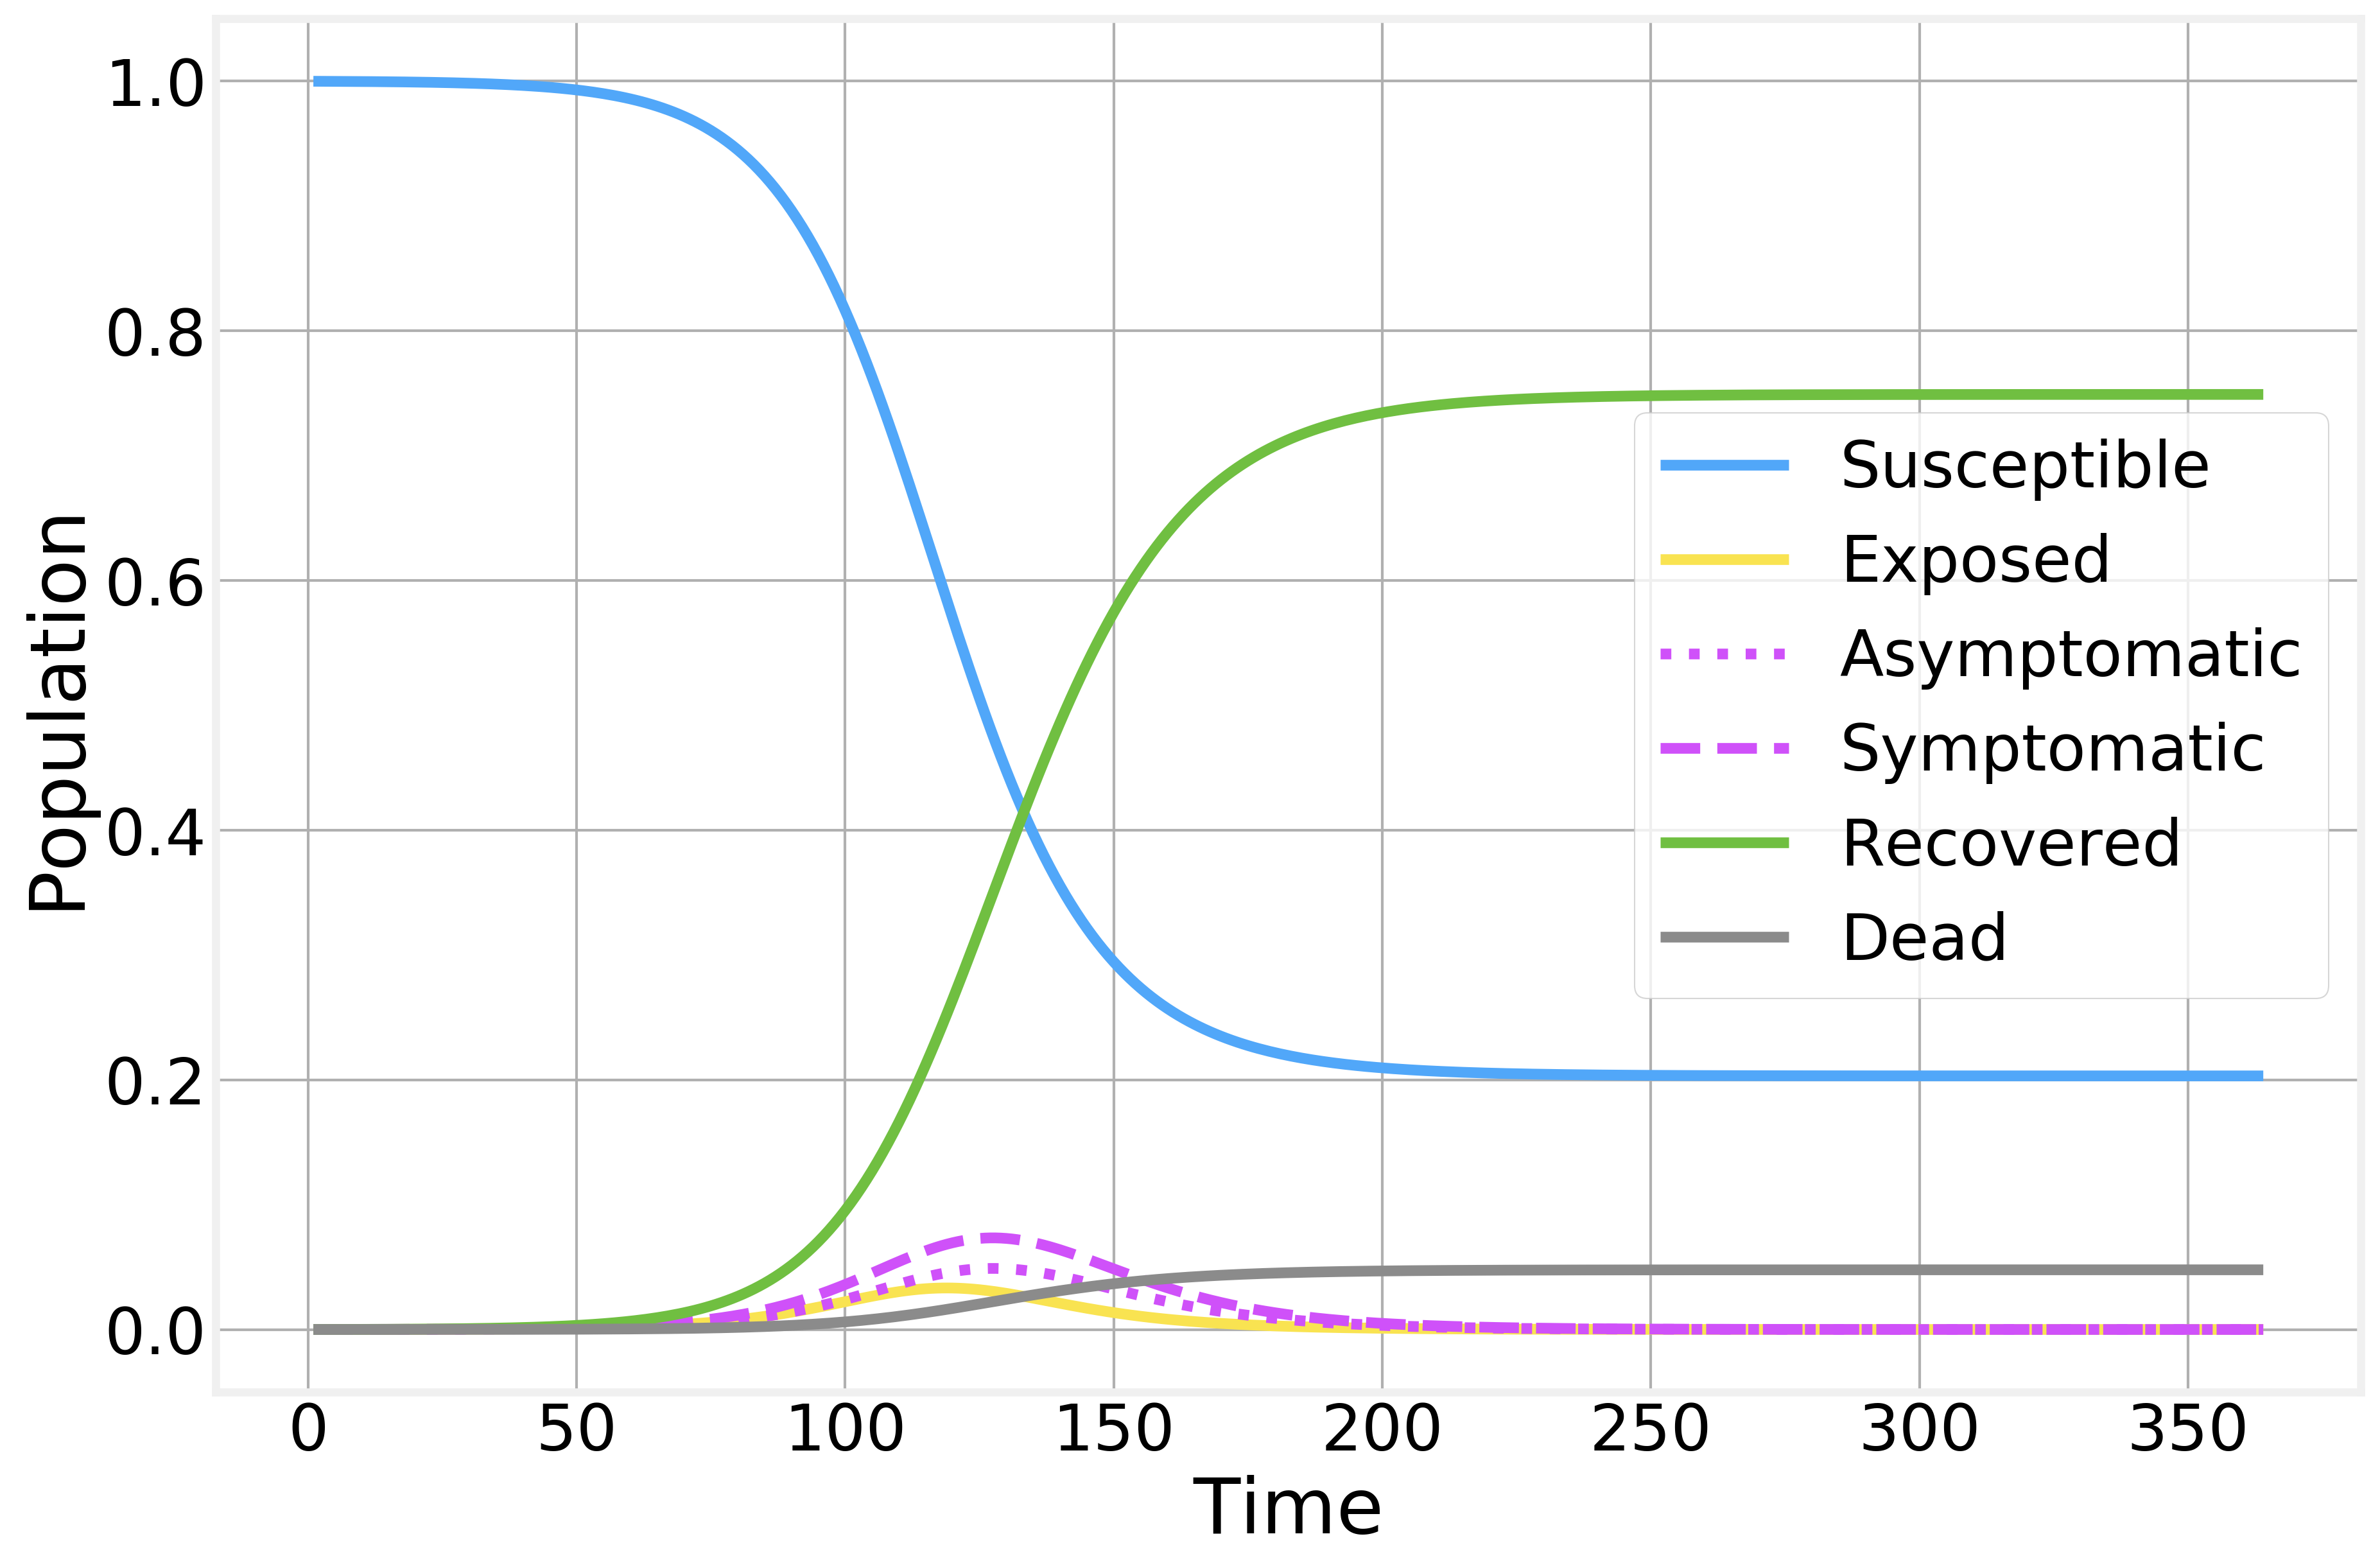

In [36]:
fig, ax = plt.subplots(1)
(SEIIRD.S/N).plot(color=colors[0], linestyle='-', label='Susceptible', ax=ax)
(SEIIRD.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(SEIIRD.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(SEIIRD.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)
(SEIIRD.R/N).plot(color=colors[2], linestyle='-', label='Recovered', ax=ax)
(SEIIRD.D/N).plot(color=colors[7], linestyle='-', label='Dead', ax=ax)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

Text(0, 0.5, 'Population')

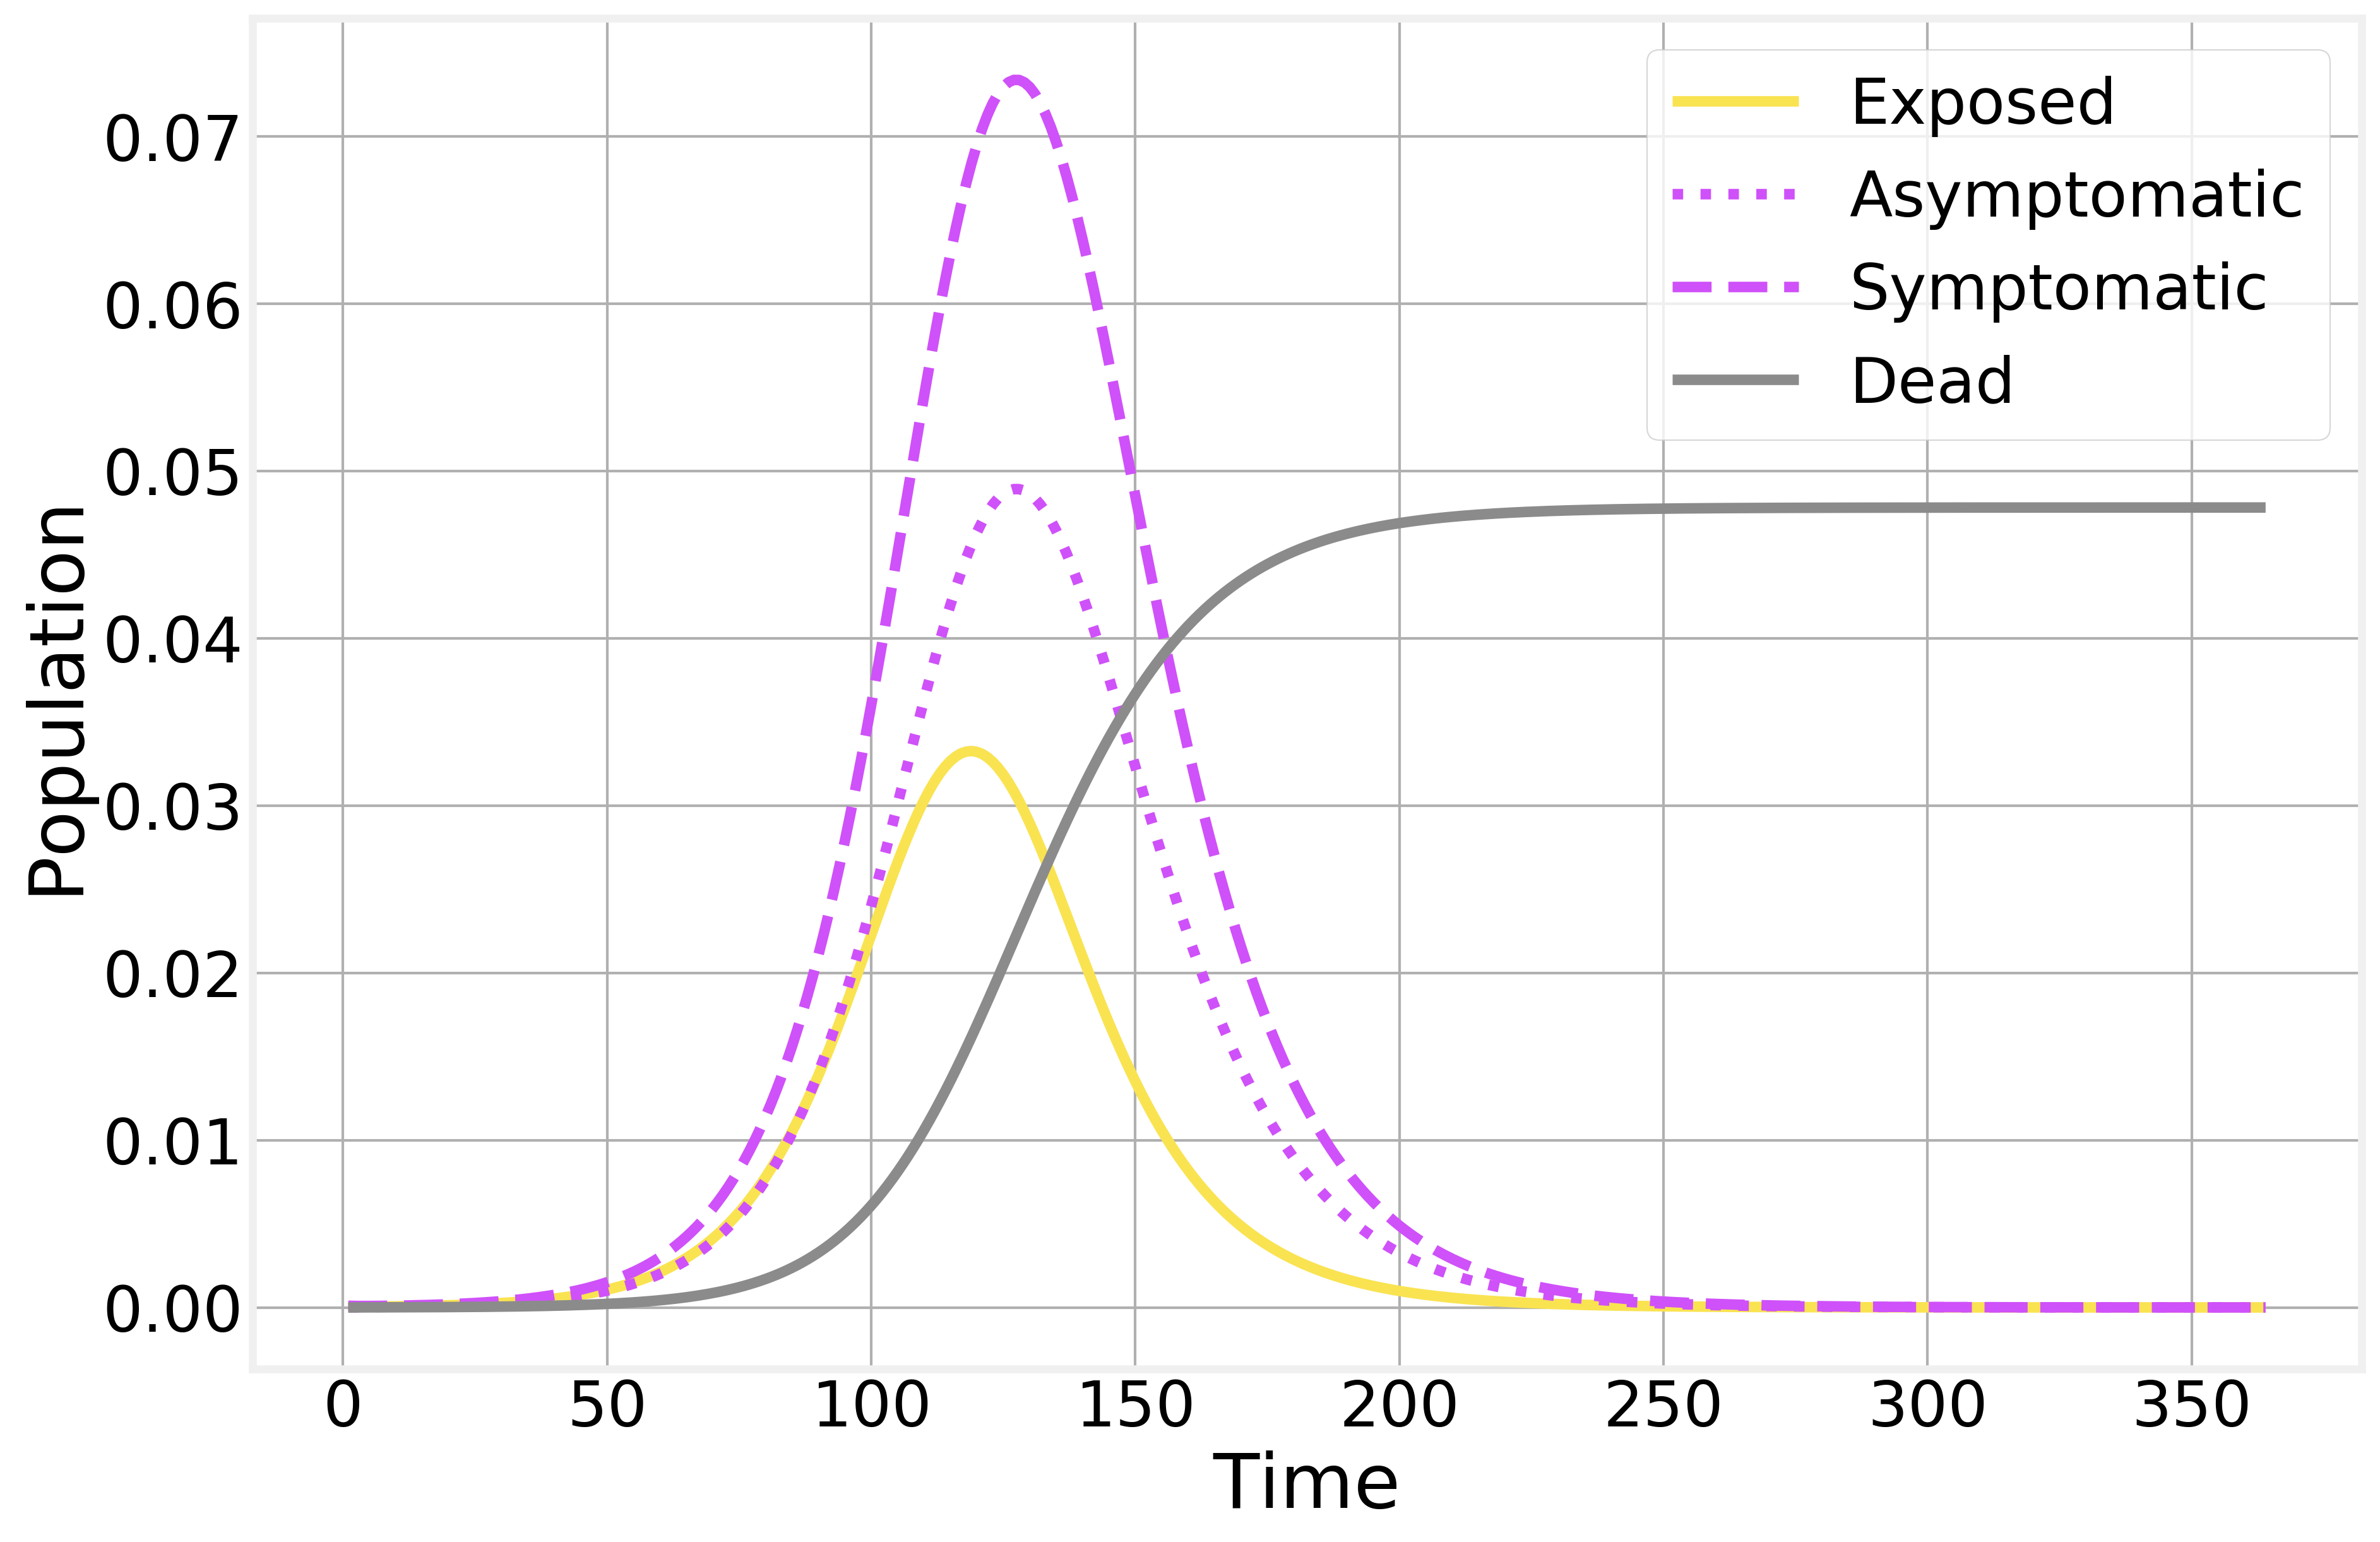

In [37]:
fig, ax = plt.subplots(1)
(SEIIRD.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(SEIIRD.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(SEIIRD.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)
(SEIIRD.D/N).plot(color=colors[7], linestyle='-', label='Dead', ax=ax)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>